## Workflow Overview

### 1. Importing Libraries
Import all required libraries for data handling, visualization, and text analysis.

---

### 2. Reading and Transforming Both Datasets
- Load both research paper and hospital datasets.
- Modified the columns of Research Paper data to get only 4 final columns ‘ID’, ‘OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS'
- For the hospital dataset, combine all columns (except `Age Group` and `Gender`) into a single text column named `Medical_Information`.
- Use only the first 50,000 rows for analysis.

---

### 3. EDA on Raw Data

- Plot 1: Most Frequent Terms in Research Papers  
- Plot 2: Papers Containing Mathematical Terms / Formulas / Equations by Section

---

### 4. Data Cleaning

- Step 1: Remove URLs  
- Step 2: Remove mathematical equations and formulas (digits and math symbols)  
- Step 3: Remove lone characters like `'n'`  
- Step 4: Remove extra spaces, newlines, and tabs  
- Step 5: Convert all text to lowercase  
- Step 6: Remove stopwords  
- Step 7: Remove punctuations

---

### 5. Pattern Discovery and Visualization on Cleaned Data

#### Univariate Analysis

- Plot 3: Top 20 Dominant Research Goals Identified from Study Objectives  
- Plot 4: How Do Medical Papers Conclude?  
  Sentiment Distribution (Pretrained Classification Patterns using VADER)  
- Plot 5: How Diverse Are Medical Methods?  
  A Cluster View using KMeans on `METHODS` section  
- Plot 6: Top Unigrams & Bigrams by Section  
  A Linguistic Snapshot

---

#### Bivariate Analysis

- Plot 7: Readability vs Length of Full Papers  
  Using Flesch Reading Ease Score (higher = easier)

---

#### Multivariate Analysis

- Plot 8: Section-wise Linguistic Analysis of Medical Papers  
  Compares:  
  - Vocabulary Richness  
  - Flesch Reading Ease  
  - Gunning Fog Index
- Plot 9:Structural Coherence Across Research (TF-IDF Cosine Semantic Pattern Alignment)

### 6. Preprocessing
 - Tokenization, Lemmatization 
 
 ### 7. Modelling
 - Task 1 - Topic Modelling
 - Task 2 - Sentiment Analysis
   
### 8. Hyperparameter Tuning

### 9. Trying on Unseen Data

## 1. Importing Libraries

In [226]:
# pip install bertopic umap-learn hdbscan gensim


In [225]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import string
import re
import pickle
import time
import pprint
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('sentiwordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from langdetect import detect, DetectorFactory
import langcodes
import textstat
from textstat import flesch_reading_ease, gunning_fog
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
import requests


In [62]:
biobert = SentenceTransformer("dmis-lab/biobert-base-cased-v1.1")

No sentence-transformers model found with name dmis-lab/biobert-base-cased-v1.1. Creating a new one with mean pooling.


## 2. Reading and transforming both the datasets

In [7]:
def parse_research_abstracts(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
   
    abstracts = re.split(r'###(\d+)', content)

    if abstracts[0].strip() == '':
        abstracts = abstracts[1:]
    data = []

    for i in range(0, len(abstracts), 2):
        if i + 1 < len(abstracts):
            research_id = abstracts[i].strip()
            abstract_text = abstracts[i + 1].strip()
            sections = defaultdict(list)
            lines = abstract_text.split('\n')
            current_section = None
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                section_match = re.match(r'^(BACKGROUND|OBJECTIVE|METHODS?|RESULTS?|CONCLUSIONS?)\s+(.+)', line)
                if section_match:
                    current_section = section_match.group(1)
                    # Normalizing section names
                    if current_section in ['METHOD', 'METHODS']:
                        current_section = 'METHODS'
                    elif current_section in ['RESULT', 'RESULTS']:
                        current_section = 'RESULTS'
                    elif current_section in ['CONCLUSION', 'CONCLUSIONS']:
                        current_section = 'CONCLUSIONS'
                    
                    sections[current_section].append(section_match.group(2))
                elif current_section:
                    sections[current_section].append(line)
            
            row_data = {'ID': research_id}
            for section, texts in sections.items():
                row_data[section] = ' '.join(texts)
            
            # Ensuring all possible columns exist (fill with empty string if missing)
            for col in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']:
                if col not in row_data:
                    row_data[col] = ''
            
            data.append(row_data)

    df = pd.DataFrame(data)
    
    # Reordering columns
    column_order = ['ID', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']
    df = df.reindex(columns=column_order)
    return df

if __name__ == "__main__":
    df = parse_research_abstracts('C://Users//Sakshi Vishwakarma//Downloads//data//train.txt')
    df = df.sample(n=20000, random_state=42)

In [8]:
df['OBJECTIVE_BACKGROUND'] = (df['OBJECTIVE'].fillna('') + ' ' + df['BACKGROUND'].fillna('')).str.strip()
df['RESULTS_CONCLUSIONS'] = (df['RESULTS'].fillna('') + ' ' + df['CONCLUSIONS'].fillna('')).str.strip()
df = df[['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 181312 to 43075
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20000 non-null  object
 1   OBJECTIVE_BACKGROUND  20000 non-null  object
 2   METHODS               20000 non-null  object
 3   RESULTS_CONCLUSIONS   20000 non-null  object
dtypes: object(4)
memory usage: 781.2+ KB


In [10]:
df.tail()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
162178,11113831,To elaborate and validate a Preschool Respirat...,A prospective cohort study was performed in 21...,"For the test group ( N = 145 ) , the best mult..."
74873,23915267,To evaluate the effectiveness of a new multifa...,Experimental study . Randomized clinical trial...,This study aims to evaluate the efficacy of a ...
151086,19243778,We tested the effect of an education and couns...,We conducted a two-group randomized controlled...,"Knowledge , attitudes and beliefs scores incre..."
109269,15825733,To determine and compare levels of sedation ac...,Prospective randomized study . 56 dogs . Dogs ...,Dogs in the acepromazine group had significant...
43075,17313003,To observe the analgesic effect of ankle-three...,Three hundred and eighty cases were randomly d...,The time inducing analgesia was 6 min in the a...


In [11]:
df.shape

(20000, 4)

In [12]:
file_path = 'C://Users//Sakshi Vishwakarma//Downloads//data//hospital-inpatient-discharges.xlsx'
data2 = pd.read_excel(file_path)

data2 = data2.head(50000)
cols_to_combine = [col for col in data2.columns if col not in ['Age Group', 'Gender']]
data2['Medical_Information'] = data2[cols_to_combine].astype(str).agg(' '.join, axis=1)
data2 = data2[['Age Group', 'Gender', 'Medical_Information']]

data2.head()

,Age Group,Gender,Medical_Information
0,18 to 29,F,0 White Not Span/Hispanic 1 Emergency INTESTIN...
1,50 to 69,M,1 White Not Span/Hispanic 15 Emergency OTHER F...
2,70 or Older,M,2 White Not Span/Hispanic 3 Emergency SECONDAR...
3,70 or Older,F,3 White Not Span/Hispanic 5 Elective REHAB/PRO...
4,70 or Older,F,4 White Not Span/Hispanic 4 Elective OSTEOARTH...


## 3. EDA on Raw Data

In [13]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

# Calculating word and sentence counts
for col in sections:
    df[col + '_wc'] = df[col].apply(lambda x: len(str(x).split()))
    df[col + '_sc'] = df[col].apply(lambda x: len(sent_tokenize(str(x))))

df[[col + '_wc' for col in sections] + [col + '_sc' for col in sections]].describe().round(2)


,OBJECTIVE_BACKGROUND_wc,METHODS_wc,RESULTS_CONCLUSIONS_wc,OBJECTIVE_BACKGROUND_sc,METHODS_sc,RESULTS_CONCLUSIONS_sc
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,50.21,93.92,160.24,2.03,3.84,5.86
std,27.76,46.28,67.70,1.21,2.09,2.31
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,29.00,65.00,115.00,1.00,2.00,4.00
50%,45.00,89.00,152.00,2.00,4.00,6.00
75%,64.00,118.00,196.00,3.00,5.00,7.00
max,349.00,1036.00,816.00,12.00,30.00,29.00


### Plot-1 : Most Frequent Terms in Research Papers

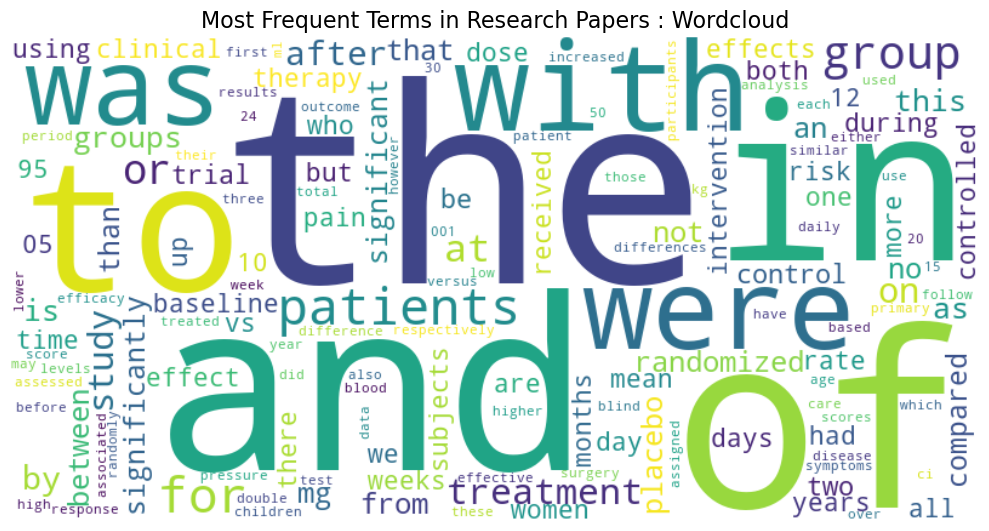

In [16]:
# Combine all sections into one long text series
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
combined_texts = df[sections].fillna('').agg(' '.join, axis=1)

def get_top_ngrams(texts, ngram_range=(1,1), top_n=100):
    vec = CountVectorizer(ngram_range=ngram_range)
    bag = vec.fit_transform(texts)
    sum_words = bag.sum(axis=0)
    words_freq = {word: sum_words[0, idx] for word, idx in vec.vocabulary_.items()}
    sorted_words = dict(sorted(words_freq.items(), key=lambda item: item[1], reverse=True)[:top_n])
    return sorted_words

top_unigrams = get_top_ngrams(combined_texts, ngram_range=(1,1), top_n=150)

wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(top_unigrams)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Terms in Research Papers : Wordcloud', fontsize=16)
plt.tight_layout()
plt.show()


### Plot-2 : Papers Containing Mathematical terms / Formulas / Equations by Section 

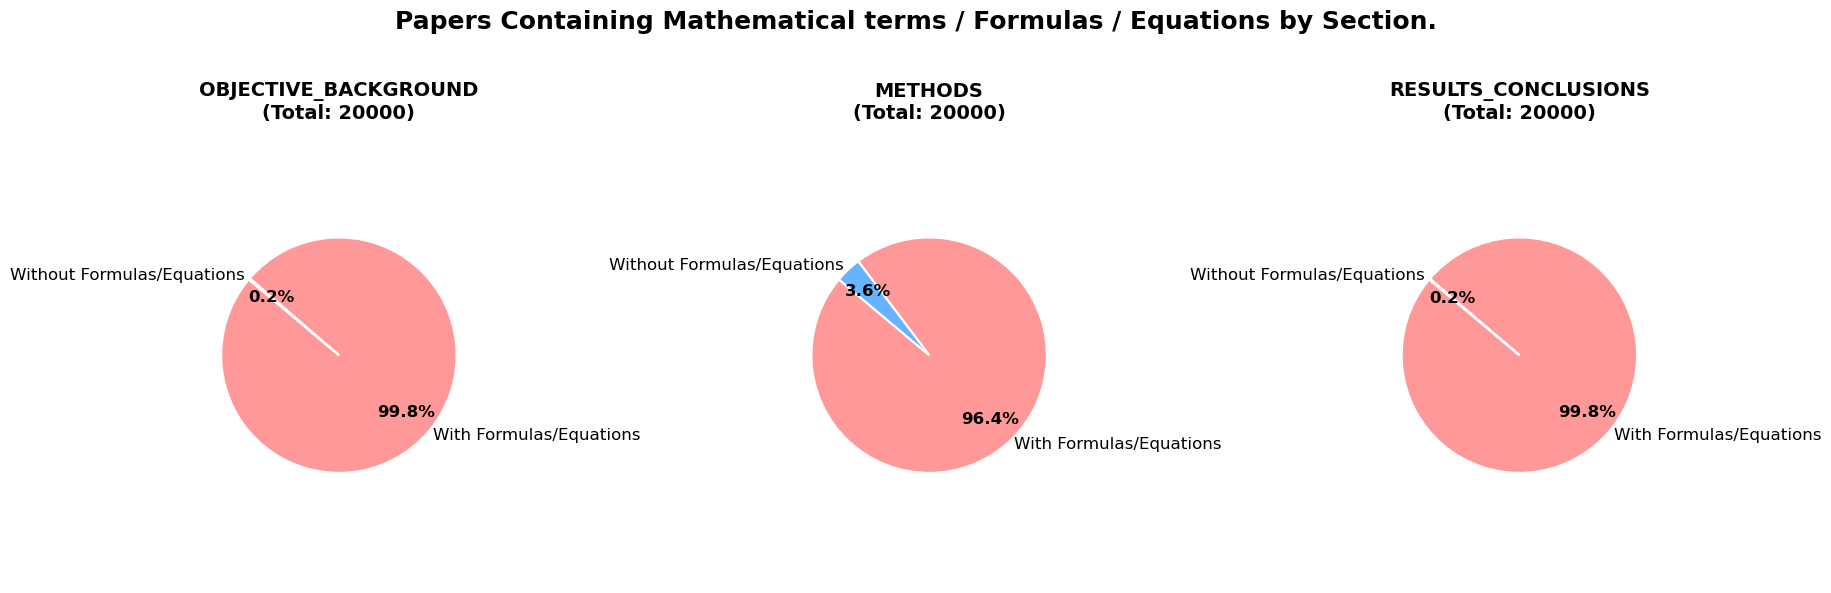

In [17]:
math_pattern = re.compile(r'[\d\.\,\+\-\*\/\=\>\<\%\(\)]+')

sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
total_entries = len(df)

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
colors = ['#ff9999', '#66b3ff']

for i, section in enumerate(sections):
    math_count = df[section].apply(lambda x: bool(math_pattern.search(str(x)))).sum()
    no_math_count = total_entries - math_count
    
    sizes = [math_count, no_math_count]
    labels = ['With Formulas/Equations', 'Without Formulas/Equations']
    
    wedges, texts, autotexts = axes[i].pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, textprops={'fontsize': 12},
        pctdistance=0.75, labeldistance=1.05,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1.5})
  
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    axes[i].set_title(f"{section}\n(Total: {total_entries})", fontsize=14, fontweight='bold')
    axes[i].axis('equal')  

plt.suptitle('Papers Containing Mathematical terms / Formulas / Equations by Section.', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [18]:
df = df[['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']]

## 4. Data Cleaning

### Step-1 : Removing URLs

In [19]:
url_pattern = re.compile(r'((https?|ftp):\/\/\S+)|(www\.\S+)|(\b\w+\.(com|org|net|edu|gov|io|ai|in|uk|co)\b)', re.IGNORECASE)

for section in sections:
    df[section] = df[section].apply(lambda x: url_pattern.sub('', str(x)))

df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers ( aged 35-59 years ; 23 females ...,Subjects using the triclosan/copolymer/fluorid...
128734,14652118,To evaluate the efficacy and safety of propofo...,"Randomized , double-blinded , placebo-controll...",The percentage of patients who were emesis-fre...
58248,17868127,This article reports lifetime Axis I and II co...,"Outpatient AN ( n = 56 ) , BN ( n = 132 ) , an...","In the AN sample as a whole , specific elevati..."
31064,22457014,Leukotriene D ( 4 ) ( LTD ( 4 ) ) is a central...,"Treatments were evaluated in a randomized , th...","Compared with placebo , salbutamol provided si..."
34665,18475165,Individual blood pressure responses to antihyp...,"In the GENRES study , 208 Finnish men aged 35-...",Serum total calcium concentration was negative...


In [20]:
df['METHODS'][181312]

'Sixty smokers ( aged 35-59 years ; 23 females ) with chronic periodontal disease volunteered to participate in a double-blind , randomized , controlled , clinical trial . The subjects were randomly assigned to use a triclosan/copolymer/fluoride ( 30 subjects ) or a standard fluoride ( 30 subjects ) dentifrice and received detailed information on proper techniques for self-performed plaque control . The participants then received non-surgical periodontal therapy followed by periodontal maintenance care every 6 months over 24 months . Clinical recordings included evaluation of oral hygiene standards , gingival health , and periodontal status .'

### Step-2 : Removing mathematical equations and formulas (digits and math symbols)

In [21]:
math_pattern = re.compile(r'[\d\.\,\+\-\*\/\=\>\<\%\(\)\[\]\{\}]+')

for section in sections:
    df[section] = df[section].apply(lambda x: math_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with ch...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled s...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN n BN n and DEP n s...,In the AN sample as a whole specific elevatio...
31064,22457014,Leukotriene D LTD is a central mediato...,Treatments were evaluated in a randomized thr...,Compared with placebo salbutamol provided sig...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years ...,Serum total calcium concentration was negative...


In [22]:
df['METHODS'][181312]

'Sixty smokers  aged  years ;  females  with chronic periodontal disease volunteered to participate in a doubleblind  randomized  controlled  clinical trial  The subjects were randomly assigned to use a triclosancopolymerfluoride   subjects  or a standard fluoride   subjects  dentifrice and received detailed information on proper techniques for selfperformed plaque control  The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every  months over  months  Clinical recordings included evaluation of oral hygiene standards  gingival health  and periodontal status '

### Step-3 : Removing lone characters like 'n'


In [23]:
lone_char_pattern = re.compile(r'\b[n]\b', re.IGNORECASE)

for section in sections:
    df[section] = df[section].apply(lambda x: lone_char_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with ch...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled s...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN BN and DEP samp...,In the AN sample as a whole specific elevatio...
31064,22457014,Leukotriene D LTD is a central mediato...,Treatments were evaluated in a randomized thr...,Compared with placebo salbutamol provided sig...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years ...,Serum total calcium concentration was negative...


In [24]:
df['METHODS'][181312]

'Sixty smokers  aged  years ;  females  with chronic periodontal disease volunteered to participate in a doubleblind  randomized  controlled  clinical trial  The subjects were randomly assigned to use a triclosancopolymerfluoride   subjects  or a standard fluoride   subjects  dentifrice and received detailed information on proper techniques for selfperformed plaque control  The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every  months over  months  Clinical recordings included evaluation of oral hygiene standards  gingival health  and periodontal status '

### Step-4 : Removing extra spaces, newlines, tabs

In [25]:
for section in sections:
    df[section] = df[section].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with chroni...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled stu...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN BN and DEP samples were assessed...,In the AN sample as a whole specific elevation...
31064,22457014,Leukotriene D LTD is a central mediator in ast...,Treatments were evaluated in a randomized thre...,Compared with placebo salbutamol provided sign...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years wit...,Serum total calcium concentration was negative...


In [26]:
df['METHODS'][181312]

'Sixty smokers aged years ; females with chronic periodontal disease volunteered to participate in a doubleblind randomized controlled clinical trial The subjects were randomly assigned to use a triclosancopolymerfluoride subjects or a standard fluoride subjects dentifrice and received detailed information on proper techniques for selfperformed plaque control The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every months over months Clinical recordings included evaluation of oral hygiene standards gingival health and periodontal status'

### Step-5 : Lowercasing all the text

In [27]:
for section in sections:
    df[section] = df[section].apply(lambda x: str(x).lower())
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking is an established risk factor ...,sixty smokers aged years ; females with chroni...,subjects using the triclosancopolymerfluoride ...
128734,14652118,to evaluate the efficacy and safety of propofo...,randomized doubleblinded placebocontrolled stu...,the percentage of patients who were emesisfree...
58248,17868127,this article reports lifetime axis i and ii co...,outpatient an bn and dep samples were assessed...,in the an sample as a whole specific elevation...
31064,22457014,leukotriene d ltd is a central mediator in ast...,treatments were evaluated in a randomized thre...,compared with placebo salbutamol provided sign...
34665,18475165,individual blood pressure responses to antihyp...,in the genres study finnish men aged years wit...,serum total calcium concentration was negative...


In [28]:
df['METHODS'][181312]

'sixty smokers aged years ; females with chronic periodontal disease volunteered to participate in a doubleblind randomized controlled clinical trial the subjects were randomly assigned to use a triclosancopolymerfluoride subjects or a standard fluoride subjects dentifrice and received detailed information on proper techniques for selfperformed plaque control the participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every months over months clinical recordings included evaluation of oral hygiene standards gingival health and periodontal status'

### Step-6 : Removing stopwords

In [29]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = str(text).split()
    filtered = [w for w in words if w not in stop_words]
    return ' '.join(filtered)

for section in sections:
    df[section] = df[section].apply(remove_stopwords)
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking established risk factor period...,sixty smokers aged years ; females chronic per...,subjects using triclosancopolymerfluoride dent...
128734,14652118,evaluate efficacy safety propofol subhypnotic ...,randomized doubleblinded placebocontrolled stu...,percentage patients emesisfree defined experie...
58248,17868127,article reports lifetime axis ii comorbidity w...,outpatient bn dep samples assessed using struc...,sample whole specific elevations found prevale...
31064,22457014,leukotriene ltd central mediator asthma induci...,treatments evaluated randomized threeperiod do...,compared placebo salbutamol provided significa...
34665,18475165,individual blood pressure responses antihypert...,genres study finnish men aged years moderate h...,serum total calcium concentration negatively c...


In [30]:
df['METHODS'][181312]

'sixty smokers aged years ; females chronic periodontal disease volunteered participate doubleblind randomized controlled clinical trial subjects randomly assigned use triclosancopolymerfluoride subjects standard fluoride subjects dentifrice received detailed information proper techniques selfperformed plaque control participants received nonsurgical periodontal therapy followed periodontal maintenance care every months months clinical recordings included evaluation oral hygiene standards gingival health periodontal status'

### Step-7 : Removing Punctuations

In [31]:
punctuation_pattern = re.compile(f"[{re.escape(string.punctuation)}]")

for section in sections:
    df[section] = df[section].apply(lambda x: punctuation_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking established risk factor period...,sixty smokers aged years females chronic peri...,subjects using triclosancopolymerfluoride dent...
128734,14652118,evaluate efficacy safety propofol subhypnotic ...,randomized doubleblinded placebocontrolled stu...,percentage patients emesisfree defined experie...
58248,17868127,article reports lifetime axis ii comorbidity w...,outpatient bn dep samples assessed using struc...,sample whole specific elevations found prevale...
31064,22457014,leukotriene ltd central mediator asthma induci...,treatments evaluated randomized threeperiod do...,compared placebo salbutamol provided significa...
34665,18475165,individual blood pressure responses antihypert...,genres study finnish men aged years moderate h...,serum total calcium concentration negatively c...


In [32]:
df['METHODS'][181312]

'sixty smokers aged years  females chronic periodontal disease volunteered participate doubleblind randomized controlled clinical trial subjects randomly assigned use triclosancopolymerfluoride subjects standard fluoride subjects dentifrice received detailed information proper techniques selfperformed plaque control participants received nonsurgical periodontal therapy followed periodontal maintenance care every months months clinical recordings included evaluation oral hygiene standards gingival health periodontal status'

## 5. Pattern Discovery and Visualization on Cleaned Data

## Univariate Analysis

### PLOT-3: Top 20 Dominant Research Goals Identified from Study Objectives 

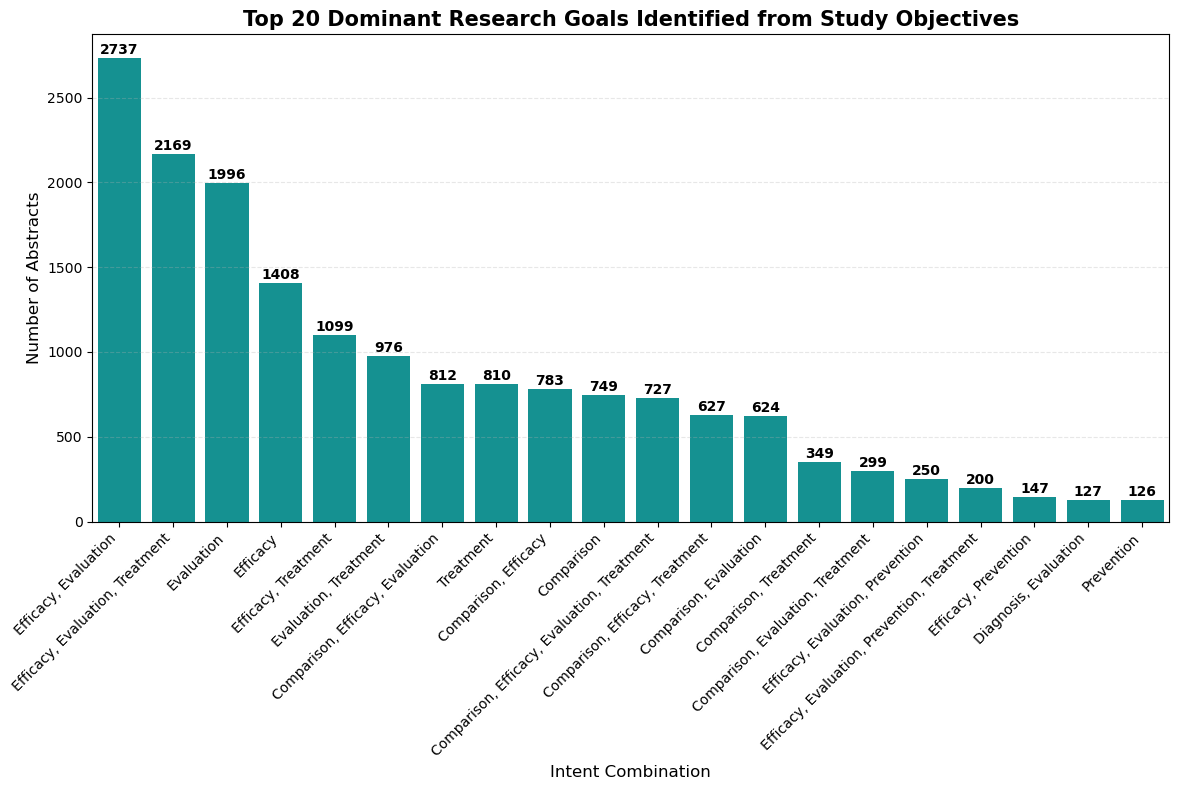

In [33]:
intent_keywords = {
    'Treatment': ['treat', 'therapy', 'therapeutic', 'intervention', 'treatment'],
    'Prevention': ['prevent', 'prevention', 'prophylaxis', 'reduce risk', 'protective'],
    'Diagnosis': ['diagnose', 'diagnostic', 'detect', 'identification', 'screening'],
    'Comparison': ['compare', 'versus', 'vs', 'comparison', 'comparative'],
    'Evaluation': ['evaluate', 'assessment', 'examine', 'investigate', 'study'],
    'Efficacy': ['efficacy', 'effectiveness', 'effect', 'outcome', 'benefit']}


def extract_intents(text):
    matched_intents = []
    text = str(text).lower()
    for intent, keywords in intent_keywords.items():
        if any(keyword in text for keyword in keywords):
            matched_intents.append(intent)
    return matched_intents

df['research_intents'] = df['OBJECTIVE_BACKGROUND'].apply(extract_intents)
df['intent_combo'] = df['research_intents'].apply(lambda x: ', '.join(sorted(x)))
df_filtered = df[df['intent_combo'] != '']


combo_counts = df_filtered['intent_combo'].value_counts().sort_values(ascending=False)
top_n = 20

plt.figure(figsize=(12, 8))
bar_color = '#00A6A6' 

sns.barplot( x=combo_counts[:top_n].index, y=combo_counts[:top_n].values, color=bar_color)
for i, count in enumerate(combo_counts[:top_n].values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title(f'Top 20 Dominant Research Goals Identified from Study Objectives', fontsize=15, fontweight='bold')
plt.ylabel('Number of Abstracts', fontsize=12)
plt.xlabel('Intent Combination', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### PLOT-4: How Do Medical Papers Conclude? Sentiment Distribution (Pretrained Classification Patterns analysis with VADER)

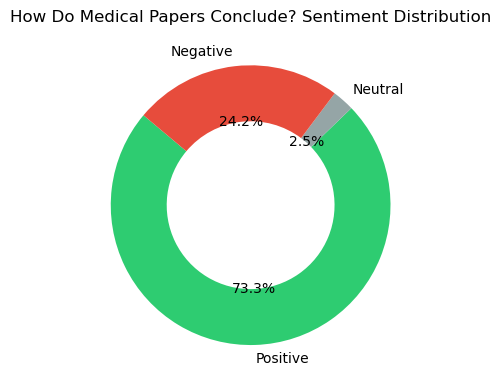

In [34]:
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['vader_class'] = df['RESULTS_CONCLUSIONS'].astype(str).apply(classify_sentiment)
sentiment_counts = df['vader_class'].value_counts().reindex(['Positive', 'Neutral', 'Negative'])

plt.figure(figsize=(4, 4))
colors = ['#2ecc71', '#95a5a6', '#e74c3c']  # green, grey, red
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4})
plt.title('How Do Medical Papers Conclude? Sentiment Distribution')
plt.tight_layout()
plt.show()


### PLOT-5: How Diverse Are Medical Methods? A Cluster View 

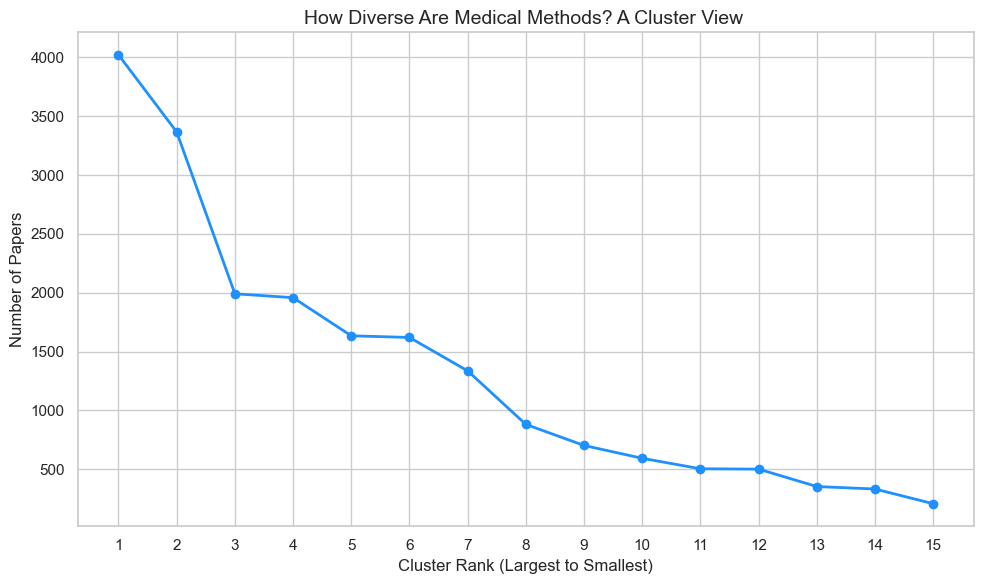

In [35]:
texts = df['METHODS'].fillna('').astype(str).tolist()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(texts)
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(X)
unique, counts = np.unique(clusters, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
sorted_sizes = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(range(1, len(sorted_sizes) + 1), [size[1] for size in sorted_sizes],marker='o', linestyle='-', color='dodgerblue', linewidth=2)
plt.title('How Diverse Are Medical Methods? A Cluster View ', fontsize=14)
plt.xlabel('Cluster Rank (Largest to Smallest)', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(range(1, len(sorted_sizes) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()


### PLOT-6: Top Unigrams & Bigrams by Section: A Linguistic Snapshot

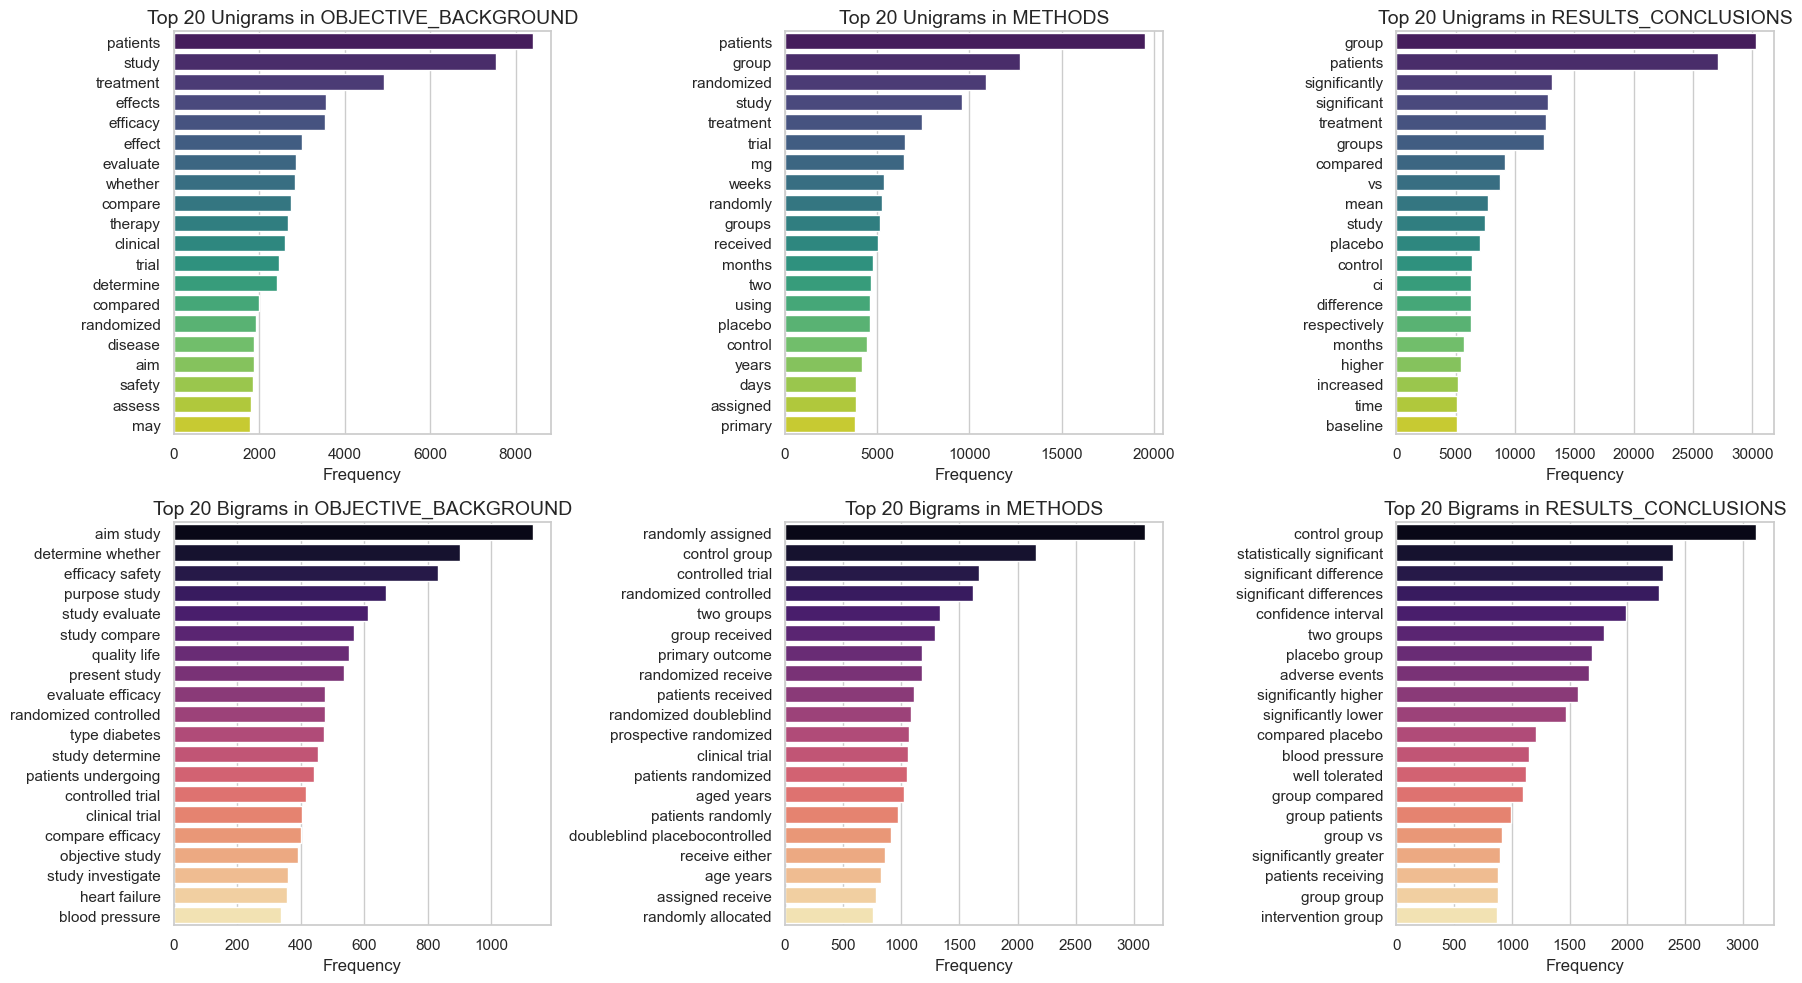

In [36]:
def get_top_ngrams(texts, ngram_range=(1,1), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range)  
    bag = vec.fit_transform(texts.dropna().astype(str))
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return zip(*words_freq) 

sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)  

for col_idx, section in enumerate(sections):
    # Unigrams
    words, freqs = get_top_ngrams(df[section], ngram_range=(1,1), top_n=20)
    sns.barplot(x=list(freqs), y=list(words), ax=axes[0, col_idx], palette='viridis')
    axes[0, col_idx].set_title(f"Top 20 Unigrams in {section}", fontsize=14)
    axes[0, col_idx].set_xlabel('Frequency', fontsize=12)
    axes[0, col_idx].set_ylabel('')
    axes[0, col_idx].tick_params(axis='y', labelsize=11)
    
    # Bigrams
    words, freqs = get_top_ngrams(df[section], ngram_range=(2,2), top_n=20)
    sns.barplot(x=list(freqs), y=list(words), ax=axes[1, col_idx], palette='magma')
    axes[1, col_idx].set_title(f"Top 20 Bigrams in {section}", fontsize=14)
    axes[1, col_idx].set_xlabel('Frequency', fontsize=12)
    axes[1, col_idx].set_ylabel('')
    axes[1, col_idx].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()


## Bivariate Analysis

### PLOT-7: Readability vs Length of Full Papers (using Flesch Reading Ease Score (higher = easier)) 

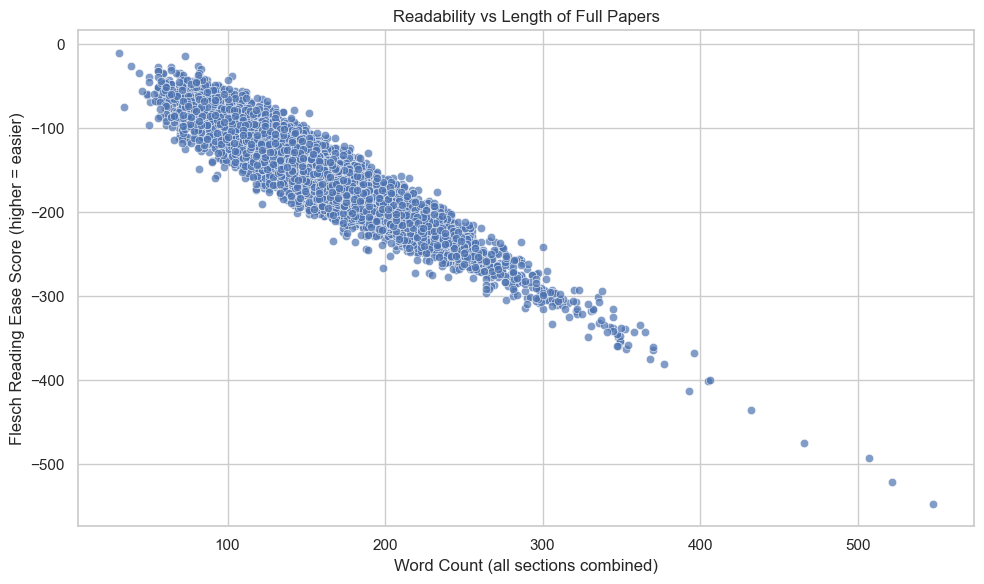

In [37]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS'] 

df['combined_text'] = df[sections].fillna('').agg(' '.join, axis=1)
df['combined_wordcount'] = df['combined_text'].apply(lambda x: len(x.split()))
df['combined_flesch'] = df['combined_text'].apply(lambda x: textstat.flesch_reading_ease(x))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='combined_wordcount', y='combined_flesch', alpha=0.7)

plt.title('Readability vs Length of Full Papers')
plt.xlabel('Word Count (all sections combined)')
plt.ylabel('Flesch Reading Ease Score (higher = easier)')
plt.grid(True)
plt.tight_layout()
plt.show()


### PLOT-8: Section-wise Linguistic Analysis of Medical Papers  

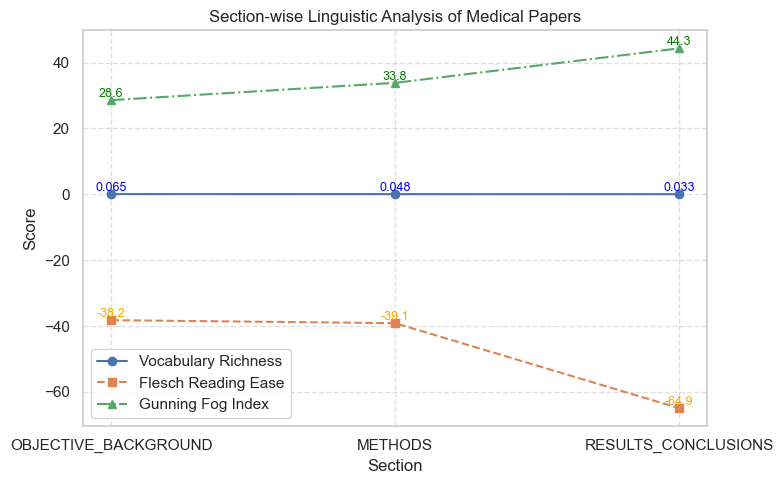

In [38]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
metrics = ['Vocabulary Richness', 'Flesch Reading Ease', 'Gunning Fog Index']

vocab_richness = []
flesch_means = []
fog_means = []

for section in sections:
    texts = df[section].dropna().astype(str)
    total_words = texts.str.split().apply(len).sum()
    all_words = " ".join(texts).split()
    unique_words = set(all_words)

    richness = len(unique_words) / total_words
    vocab_richness.append(richness)

    sampled_texts = texts.sample(min(500, len(texts)), random_state=42)
    flesch = sampled_texts.apply(flesch_reading_ease).mean()
    fog = sampled_texts.apply(gunning_fog).mean()

    flesch_means.append(flesch)
    fog_means.append(fog)

plt.figure(figsize=(8, 5))
plt.plot(sections, vocab_richness, marker='o', linestyle='-', label='Vocabulary Richness')
plt.plot(sections, flesch_means, marker='s', linestyle='--', label='Flesch Reading Ease')
plt.plot(sections, fog_means, marker='^', linestyle='-.', label='Gunning Fog Index')

for i, section in enumerate(sections):
    plt.text(section, vocab_richness[i], f"{vocab_richness[i]:.3f}", ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(section, flesch_means[i], f"{flesch_means[i]:.1f}", ha='center', va='bottom', fontsize=9, color='orange')
    plt.text(section, fog_means[i], f"{fog_means[i]:.1f}", ha='center', va='bottom', fontsize=9, color='green')

plt.title('Section-wise Linguistic Analysis of Medical Papers')
plt.xlabel('Section')
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [39]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

print("Section-wise Text Metrics:\n")
print(f"{'Section':25} | {'Vocab Richness':15} | {'Flesch Reading Ease':20} | {'Gunning Fog Index':18}")
print("-"*85)

for i, section in enumerate(sections):
    print(f"{section:25} | {vocab_richness[i]:15.4f} | {flesch_means[i]:20.2f} | {fog_means[i]:18.2f}")


Section-wise Text Metrics:

Section                   | Vocab Richness  | Flesch Reading Ease  | Gunning Fog Index 
-------------------------------------------------------------------------------------
OBJECTIVE_BACKGROUND      |          0.0646 |               -38.22 |              28.59
METHODS                   |          0.0481 |               -39.13 |              33.84
RESULTS_CONCLUSIONS       |          0.0326 |               -64.93 |              44.30


### PLOT-9: Structural Coherence Across Research (TF-IDF Cosine Semantic Pattern Alignment) 

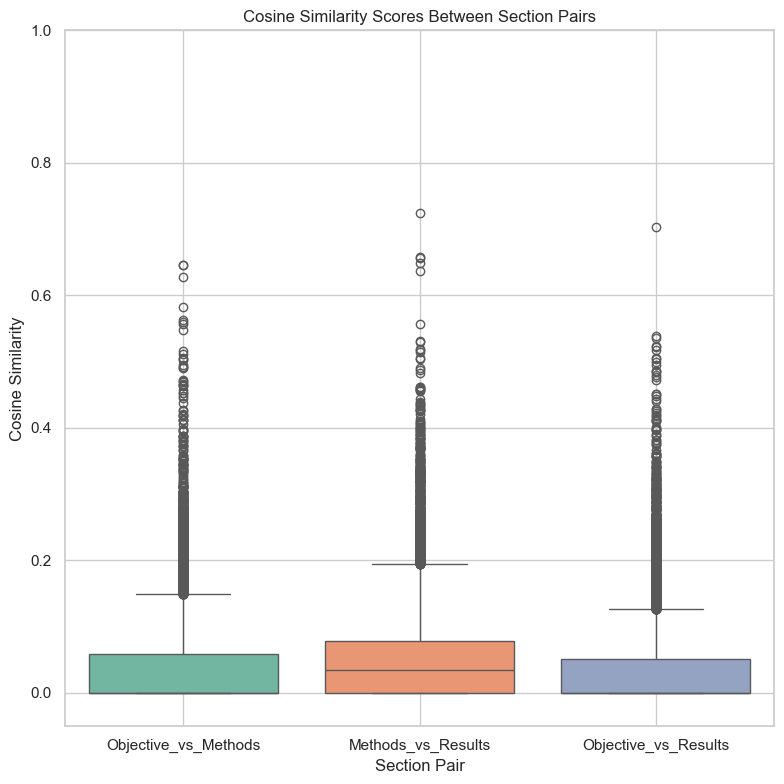

In [40]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

for sec in sections:
    df[sec] = df[sec].fillna('').astype(str)
vectorizer = TfidfVectorizer(max_features=500)
tfidf_objective = vectorizer.fit_transform(df['OBJECTIVE_BACKGROUND'])
tfidf_methods = vectorizer.fit_transform(df['METHODS'])
tfidf_results = vectorizer.fit_transform(df['RESULTS_CONCLUSIONS'])


def rowwise_cosine(mat1, mat2):
    return [cosine_similarity(mat1[i], mat2[i])[0][0] for i in range(mat1.shape[0])]

df['Objective_vs_Methods'] = rowwise_cosine(tfidf_objective, tfidf_methods)
df['Methods_vs_Results'] = rowwise_cosine(tfidf_methods, tfidf_results)
df['Objective_vs_Results'] = rowwise_cosine(tfidf_objective, tfidf_results)

sim_df = pd.melt(df[['Objective_vs_Methods', 'Methods_vs_Results', 'Objective_vs_Results']],var_name='Section Pair',value_name='Cosine Similarity')

plt.figure(figsize=(8,8))
sns.boxplot(data=sim_df, x='Section Pair', y='Cosine Similarity', palette='Set2')
plt.title('Cosine Similarity Scores Between Section Pairs')
plt.ylim(sim_df['Cosine Similarity'].min() - 0.05, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Pre Processing

In [42]:
print("Loading and preparing data...")

def preprocess_text(text):
    """Complete text preprocessing pipeline"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+[\.\d]*', '', text) 
    text = re.sub(r'[+\-*/=<>(){}[\]%]', '', text) 
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Applying preprocessing to all sections
print("Preprocessing text sections...")
df['OBJECTIVE_BACKGROUND_clean'] = df['OBJECTIVE_BACKGROUND'].apply(preprocess_text)
df['METHODS_clean'] = df['METHODS'].apply(preprocess_text)
df['RESULTS_CONCLUSIONS_clean'] = df['RESULTS_CONCLUSIONS'].apply(preprocess_text)

# Creating combined text for overall analysis
df['full_text_clean'] = (df['OBJECTIVE_BACKGROUND_clean'] + ' ' + df['METHODS_clean'] + ' ' + df['RESULTS_CONCLUSIONS_clean']).str.strip()
df = df[df['full_text_clean'].str.len() > 10].reset_index(drop=True)
print(f"Data shape after preprocessing: {df.shape}")


Loading and preparing data...
Preprocessing text sections...
Data shape after preprocessing: (20000, 17)


In [63]:
df.columns

Index(['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS',
       'research_intents', 'intent_combo', 'vader_class', 'combined_text',
       'combined_wordcount', 'combined_flesch', 'Objective_vs_Methods',
       'Methods_vs_Results', 'Objective_vs_Results',
       'OBJECTIVE_BACKGROUND_clean', 'METHODS_clean',
       'RESULTS_CONCLUSIONS_clean', 'full_text_clean'],
      dtype='object')

# 7. Modelling

## Task 1 - Topic Modelling

In [198]:
# ====== DATA ======
texts = (df['OBJECTIVE_BACKGROUND_clean'].fillna('') + ' ' + df['METHODS_clean'].fillna('')).tolist()
n_topics = 20

# ====== HELPERS ======
def topic_diversity(model, vectorizer=None, n_words=10):
    seen = set()
    total = 0
    if hasattr(model, 'components_'):
        feature_names = vectorizer.get_feature_names_out()
        for topic in model.components_:
            words = [feature_names[i] for i in topic.argsort()[-n_words:]]
            seen.update(words)
            total += len(words)
    return len(seen) / total if total > 0 else 0

def topic_entropy(topics):
    topics = [t for t in topics if t >= 0]  # remove outliers
    topic_counts = np.bincount(topics)
    probs = topic_counts / topic_counts.sum()
    return -np.sum([p * np.log2(p) for p in probs if p > 0])


def compute_coherence(texts, topic_words):
    tokenized_texts = [nltk.word_tokenize(doc.lower()) for doc in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    cm = CoherenceModel(topics=topic_words, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

def show_topic_details(name, labels, topic_words):
    print(f"\n{'=' * 30} {name} TOPICS {'=' * 30}")
    for i, words in enumerate(topic_words):
        count = (np.array(labels) == i).sum()
        print(f"\n----- Topic {i} ({count} docs) -----\n{', '.join(words)}")


In [ ]:
# ====== LDA ======
vectorizer_lda = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X_lda = vectorizer_lda.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, learning_method='online', random_state=42)
lda_topics = lda.fit_transform(X_lda)
lda_labels = np.argmax(lda_topics, axis=1)

lda_words = []
for topic in lda.components_:
    words = [vectorizer_lda.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    lda_words.append(words)

# ====== NMF ======
vectorizer_nmf = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
X_nmf = vectorizer_nmf.fit_transform(texts)

nmf = NMF(n_components=n_topics, random_state=42, max_iter=200)
nmf_topics = nmf.fit_transform(X_nmf)
nmf_labels = np.argmax(nmf_topics, axis=1)

nmf_words = []
for topic in nmf.components_:
    words = [vectorizer_nmf.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    nmf_words.append(words)

# ====== BERTopic + BioBERT ======
biobert_model = SentenceTransformer("dmis-lab/biobert-base-cased-v1.1")
embeddings = biobert_model.encode(texts, show_progress_bar=True)

umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', prediction_data=True)

bertopic_model = BERTopic(
    embedding_model=biobert_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=n_topics,
    verbose=True
)





In [ ]:
bertopic_model.save("bertopic_biobert_model", save_embedding_model=True)
from bertopic import BERTopic
bertopic_model = BERTopic.load("bertopic_biobert_model")

bertopic_labels, probs = bertopic_model.fit_transform(texts)
bertopic_words = [words for _, words in bertopic_model.get_topics().items()]

import pickle
with open("embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)
with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2025-07-23 20:58:25,952 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-23 20:59:22,952 - BERTopic - Dimensionality - Completed ✓
2025-07-23 20:59:22,963 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-23 20:59:25,762 - BERTopic - Cluster - Completed ✓
2025-07-23 20:59:25,762 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-23 20:59:31,082 - BERTopic - Representation - Completed ✓
2025-07-23 20:59:31,095 - BERTopic - Topic reduction - Reducing number of topics
2025-07-23 20:59:31,399 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-23 20:59:36,977 - BERTopic - Representation - Completed ✓
2025-07-23 20:59:37,005 - BERTopic - Topic reduction - Reduced number of topics from 77 to 20



============================== BASELINE COMPARISON TABLE ==============================
              Model  Diversity   Entropy  Coherence
0               LDA      0.670  3.842344   0.474167
1               NMF      0.875  4.222450   0.728656
2  BERTopic-BioBERT      0.730  3.327801   0.629696


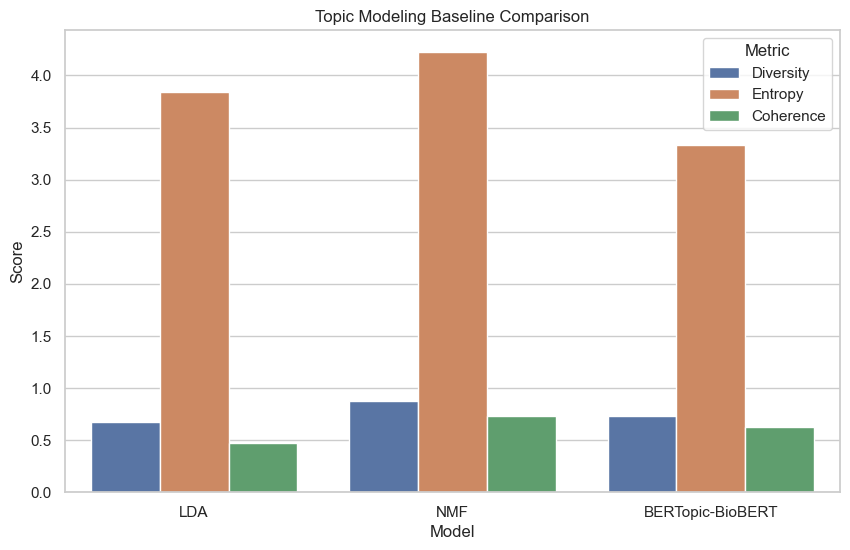


============================== LDA TOPICS ==============================

----- Topic 0 (1616 docs) -----
efficacy, symptom, randomized, daily, placebo, study, day, patient, treatment, week

----- Topic 1 (947 docs) -----
treatment, stage, day, mgm, trial, breast, chemotherapy, survival, cancer, patient

----- Topic 2 (761 docs) -----
patient, mass, diet, glucose, insulin, type, body, weight, diabetes, pain

----- Topic 3 (2124 docs) -----
dose, week, placebo, safety, trial, treatment, efficacy, randomized, study, patient

----- Topic 4 (130 docs) -----
area, reaction, water, tissue, child, emergency, solution, wound, skin, mgkg

----- Topic 5 (360 docs) -----
heart, strength, functional, function, knee, week, muscle, stroke, test, exercise

----- Topic 6 (443 docs) -----
corticosteroid, hepatitis, microg, day, hiv, vaccine, week, patient, therapy, infection

----- Topic 7 (1015 docs) -----
case, divided, treated, received, randomly, effect, treatment, control, patient, group

----- T

In [72]:

# ====== METRICS ======
results = []

results.append({
    'Model': 'LDA',
    'Diversity': topic_diversity(lda, vectorizer_lda),
    'Entropy': topic_entropy(lda_labels),
    'Coherence': compute_coherence(texts, lda_words)
})

results.append({
    'Model': 'NMF',
    'Diversity': topic_diversity(nmf, vectorizer_nmf),
    'Entropy': topic_entropy(nmf_labels),
    'Coherence': compute_coherence(texts, nmf_words)
})

results.append({
    'Model': 'BERTopic-BioBERT',
    'Diversity': len(set(sum(bertopic_words, []))) / (n_topics * 10),
    'Entropy': topic_entropy(bertopic_labels),
    'Coherence': compute_coherence(texts, bertopic_words)
})

results_df = pd.DataFrame(results)
print(f"\n{'=' * 30} BASELINE COMPARISON TABLE {'=' * 30}")
print(results_df)

# ====== PLOT ======
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Topic Modeling Baseline Comparison")
plt.ylabel("Score")
plt.legend(title='Metric')
plt.show()

# ====== TOPIC DETAILS ======
show_topic_details("LDA", lda_labels, lda_words)
show_topic_details("NMF", nmf_labels, nmf_words)
show_topic_details("BERTopic-BioBERT", bertopic_labels, bertopic_words)


In [88]:
API_KEY = "3e486e8e-0257-47f5-a6c2-1ab943a8a538"
HEADERS = {'Authorization': f'apikey token={API_KEY}'}

def search_mesh(term):
    """Search MeSH ontology on BioPortal for a term and return list of matches."""
    import requests
    url = f"https://data.bioontology.org/search?q={term}&ontologies=MSH&require_exact_match=false"
    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            results = response.json().get('collection', [])
            # Return all prefLabels (not just first)
            return [res.get('prefLabel') for res in results if res.get('prefLabel')]
    except Exception as e:
        print(f"Error for term {term}: {e}")
    return []

def auto_name_topic(words, min_freq=2):
    """
    For given topic words, query MeSH and aggregate results.
    Return the most frequent medical concept that appears >= min_freq times.
    Else, fallback to join top 2-3 words.
    """
    concept_counter = Counter()
    for word in words:
        mesh_terms = search_mesh(word)
        if mesh_terms:
            concept_counter.update(mesh_terms)
        time.sleep(0.1)  # to respect API rate limits
    
    # Filter terms that appear at least min_freq times
    filtered = [(term, count) for term, count in concept_counter.items() if count >= min_freq]
    if filtered:
        # Sort by count descending, pick top
        filtered.sort(key=lambda x: x[1], reverse=True)
        return filtered[0][0]  # most frequent concept
    else:
        # fallback: join top 2 words that have longest length (likely multiword medical terms)
        longest_words = sorted(words, key=lambda w: len(w), reverse=True)[:2]
        return " ".join(longest_words)

def auto_name_all_topics(topic_words_list):
    topic_names = []
    for words in topic_words_list:
        name = auto_name_topic(words)
        topic_names.append(name)
    return topic_names


In [89]:
lda_names = auto_name_all_topics(lda_words)
nmf_names = auto_name_all_topics(nmf_words)
bertopic_names = auto_name_all_topics(bertopic_words)


In [91]:
def topic_summary_df(labels, topic_words, topic_names, model_name):
    doc_counts = pd.Series(labels).value_counts().sort_index()
    rows = []
    for i, words in enumerate(topic_words):
        rows.append({
            "Model": model_name,
            "Topic ID": i,
            "Topic Name": topic_names[i],
            "Top Words": ', '.join(words),
            "Doc Count": int(doc_counts.get(i, 0))
        })
    return pd.DataFrame(rows)

lda_df = topic_summary_df(lda_labels, lda_words, lda_names, "LDA")
nmf_df = topic_summary_df(nmf_labels, nmf_words, nmf_names, "NMF")
bertopic_df = topic_summary_df(bertopic_labels, bertopic_words, bertopic_names, "BERTopic-BioBERT")

summary_df = pd.concat([lda_df, nmf_df, bertopic_df], ignore_index=True)
display(summary_df)


,Model,Topic ID,Topic Name,Top Words,Doc Count
0,LDA,0,randomized treatment,"efficacy, symptom, randomized, daily, placebo,...",1616
1,LDA,1,chemotherapy treatment,"treatment, stage, day, mgm, trial, breast, che...",947
2,LDA,2,diabetes patient,"patient, mass, diet, glucose, insulin, type, b...",761
3,LDA,3,randomized treatment,"dose, week, placebo, safety, trial, treatment,...",2124
4,LDA,4,emergency reaction,"area, reaction, water, tissue, child, emergenc...",130
5,LDA,5,functional strength,"heart, strength, functional, function, knee, w...",360
6,LDA,6,corticosteroid hepatitis,"corticosteroid, hepatitis, microg, day, hiv, v...",443
7,LDA,7,treatment received,"case, divided, treated, received, randomly, ef...",1015
8,LDA,8,association clinical,"control, used, clinical, food, association, sa...",485
9,LDA,9,hypertension response,"response, level, effect, study, injury, cell, ...",501


In [94]:
def plot_topic_distribution_pie(df, model_name):
    """Plot pie chart for topic distribution for a given model."""
    model_df = df[df["Model"] == model_name]
    labels = model_df["Topic Name"]
    sizes = model_df["Doc Count"]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
    plt.title(f"Document Topic Distribution - {model_name}")
    plt.tight_layout()
    plt.show()


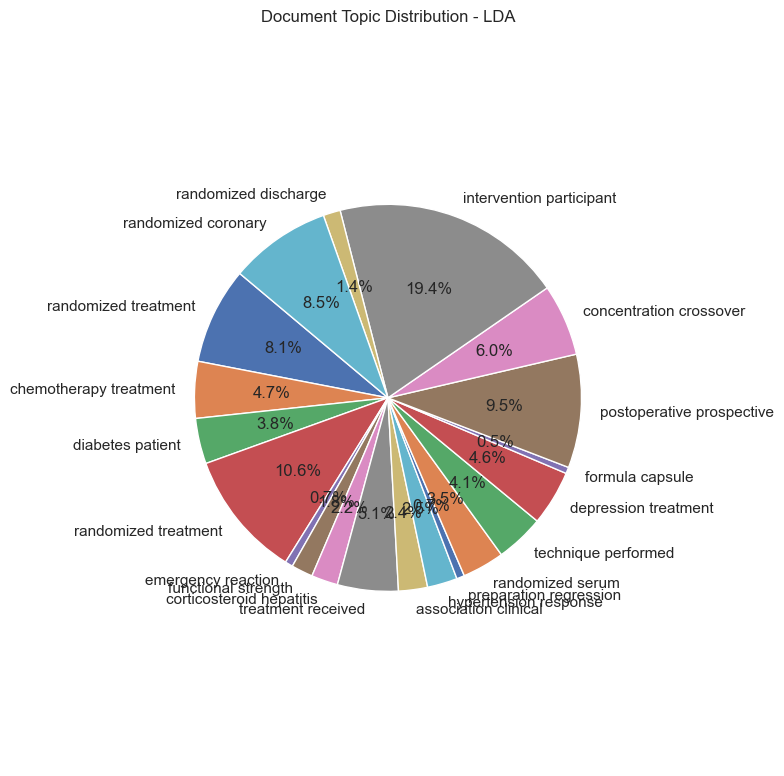

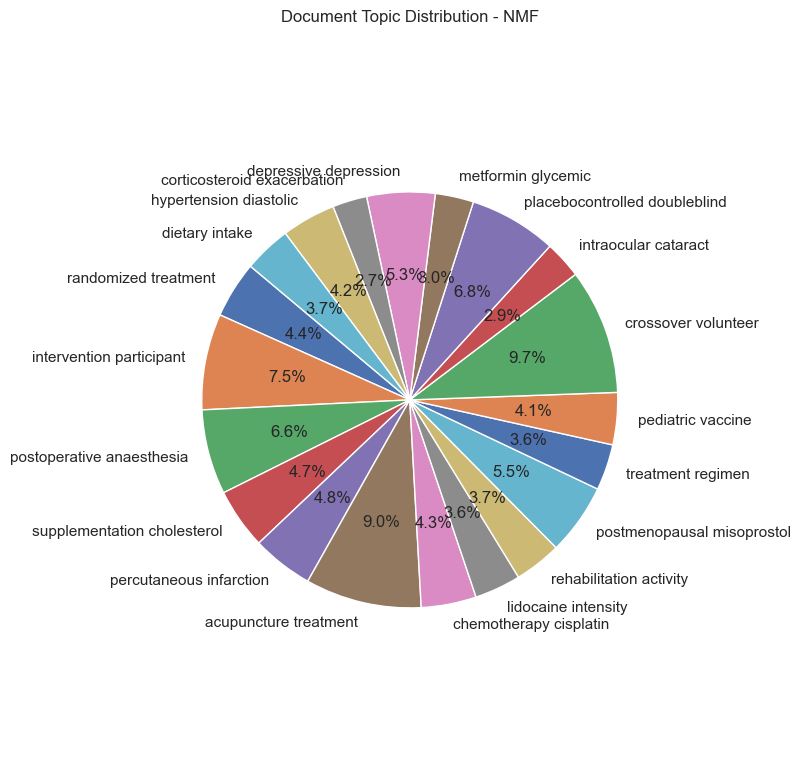

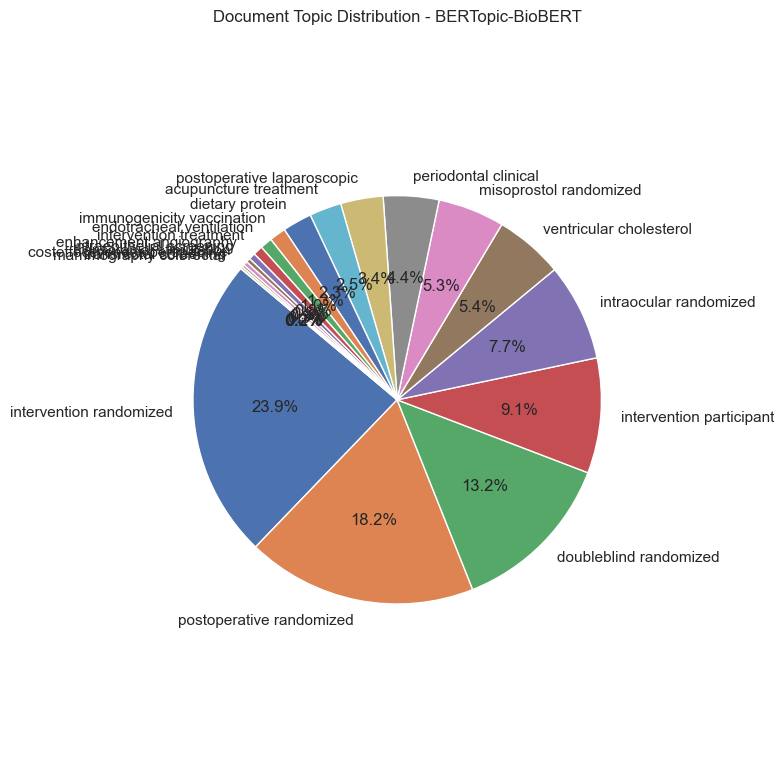

In [95]:
plot_topic_distribution_pie(summary_df, "LDA")
plot_topic_distribution_pie(summary_df, "NMF")
plot_topic_distribution_pie(summary_df, "BERTopic-BioBERT")


In [96]:
def count_unassigned(labels):
    return sum(1 for label in labels if label == -1)
lda_unassigned = count_unassigned(lda_labels)
nmf_unassigned = count_unassigned(nmf_labels)
bertopic_unassigned = count_unassigned(bertopic_labels)

total_docs = len(lda_labels) 

print(f"LDA: {lda_unassigned} docs unassigned ({lda_unassigned / total_docs:.2%})")
print(f"NMF: {nmf_unassigned} docs unassigned ({nmf_unassigned / total_docs:.2%})")
print(f"BERTopic: {bertopic_unassigned} docs unassigned ({bertopic_unassigned / total_docs:.2%})")


LDA: 0 docs unassigned (0.00%)
NMF: 0 docs unassigned (0.00%)
BERTopic: 7933 docs unassigned (39.66%)


## Hyperparameter Tuning



Tuning BERTopic with PCA+KMeans - Combination 1/5: {'pca_n_components': 5, 'kmeans_n_clusters': 15}

Tuning BERTopic with PCA+KMeans - Combination 2/5: {'pca_n_components': 10, 'kmeans_n_clusters': 20}

Tuning BERTopic with PCA+KMeans - Combination 3/5: {'pca_n_components': 15, 'kmeans_n_clusters': 25}

Tuning BERTopic with PCA+KMeans - Combination 4/5: {'pca_n_components': 20, 'kmeans_n_clusters': 30}

Tuning BERTopic with PCA+KMeans - Combination 5/5: {'pca_n_components': 10, 'kmeans_n_clusters': 15}

================ BERTopic with PCA+KMeans Tuning Results ================


,Combination,Params,Diversity,Entropy,Coherence,Num Topics (excluding noise),Unassigned Docs,% Unassigned
0,1,"{'pca_n_components': 5, 'kmeans_n_clusters': 15}",0.290,3.8528,0.5013,15,0,0.00%
1,2,"{'pca_n_components': 10, 'kmeans_n_clusters': 20}",0.410,4.2712,0.5300,20,0,0.00%
2,3,"{'pca_n_components': 15, 'kmeans_n_clusters': 25}",0.510,4.1634,0.5790,20,0,0.00%
3,4,"{'pca_n_components': 20, 'kmeans_n_clusters': 30}",0.570,4.0751,0.5942,20,0,0.00%
4,5,"{'pca_n_components': 10, 'kmeans_n_clusters': 15}",0.335,3.8687,0.5093,15,0,0.00%


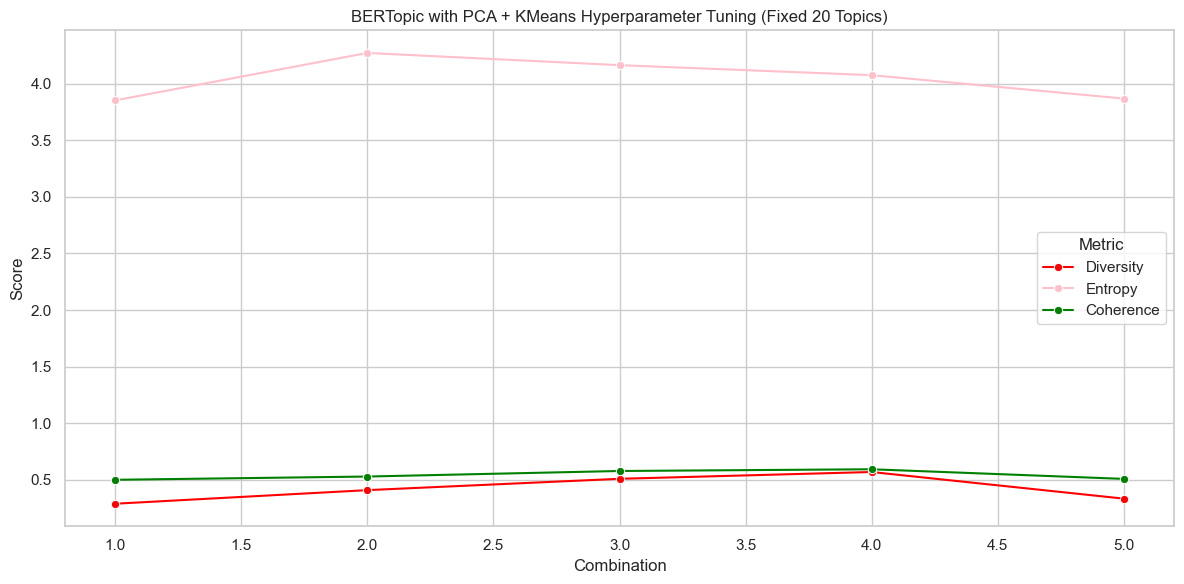

In [188]:
with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

from bertopic import BERTopic
bertopic_model = BERTopic.load("bertopic_biobert_model")

# Hyperparameter grid for PCA + KMeans
param_grid = [
    {'pca_n_components': 5, 'kmeans_n_clusters': 15},
    {'pca_n_components': 10, 'kmeans_n_clusters': 20},
    {'pca_n_components': 15, 'kmeans_n_clusters': 25},
    {'pca_n_components': 20, 'kmeans_n_clusters': 30},
    {'pca_n_components': 10, 'kmeans_n_clusters': 15},]

results = []

for i, params in enumerate(param_grid):
    print(f"\nTuning BERTopic with PCA+KMeans - Combination {i+1}/{len(param_grid)}: {params}")

    topic_model = BERTopic(
        embedding_model=biobert_model,
        nr_topics=nr_topics,
        verbose=False,
        calculate_probabilities=True)
    
    # Override default models
    topic_model.umap_model = PCA(n_components=params['pca_n_components'], random_state=42)
    topic_model.hdbscan_model = KMeans(n_clusters=params['kmeans_n_clusters'], random_state=42)
    
    topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)
    all_topics = topic_model.get_topics()
    topic_words = [[word for word, _ in all_topics[i]] for i in all_topics if i != -1]

    num_unassigned = sum(t == -1 for t in topics)
    pct_unassigned = num_unassigned / len(topics)

    diversity = len(set(sum(topic_words, []))) / (nr_topics * 10)
    entropy = topic_entropy(topics)
    coherence = compute_coherence(texts, topic_words)

    results.append({
        'Combination': i + 1,
        'Params': params,
        'Diversity': round(diversity, 4),
        'Entropy': round(entropy, 4),
        'Coherence': round(coherence, 4),
        'Num Topics (excluding noise)': len(set(t for t in topics if t != -1)),
        'Unassigned Docs': num_unassigned,
        '% Unassigned': f"{pct_unassigned:.2%}" })

results_df = pd.DataFrame(results)

print("\n================ BERTopic with PCA+KMeans Tuning Results ================")
display(results_df)

# Plotting
plot_data = results_df.melt(
    id_vars='Combination',
    value_vars=['Diversity', 'Entropy', 'Coherence'],
    var_name='Metric')

custom_palette = {
    'Diversity': 'red',
    'Entropy': 'pink',
    'Coherence': 'green'}

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_data, x='Combination', y='value', hue='Metric', marker='o', palette=custom_palette)
plt.title("BERTopic with PCA + KMeans Hyperparameter Tuning (Fixed 20 Topics)")
plt.xlabel("Combination")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()



Tuning BERTopic with PCA+KMeans - Combination 1/5: {'pca_n_components': 5, 'kmeans_n_clusters': 20, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'}

Tuning BERTopic with PCA+KMeans - Combination 2/5: {'pca_n_components': 10, 'kmeans_n_clusters': 25, 'kmeans_init': 'random', 'pca_svd_solver': 'full'}

Tuning BERTopic with PCA+KMeans - Combination 3/5: {'pca_n_components': 15, 'kmeans_n_clusters': 30, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'arpack'}

Tuning BERTopic with PCA+KMeans - Combination 4/5: {'pca_n_components': 20, 'kmeans_n_clusters': 20, 'kmeans_init': 'random', 'pca_svd_solver': 'randomized'}

Tuning BERTopic with PCA+KMeans - Combination 5/5: {'pca_n_components': 10, 'kmeans_n_clusters': 15, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'}

================ BERTopic with PCA+KMeans Tuning Results ================


,Combination,Params,Diversity,Entropy,Coherence,Unassigned Docs,% Unassigned
0,1,"{'pca_n_components': 5, 'kmeans_n_clusters': 20, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'}",0.330,4.2796,0.5193,0,0.00%
1,2,"{'pca_n_components': 10, 'kmeans_n_clusters': 25, 'kmeans_init': 'random', 'pca_svd_solver': 'full'}",0.460,4.1756,0.5466,0,0.00%
2,3,"{'pca_n_components': 15, 'kmeans_n_clusters': 30, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'arpack'}",0.540,4.1620,0.5833,0,0.00%
3,4,"{'pca_n_components': 20, 'kmeans_n_clusters': 20, 'kmeans_init': 'random', 'pca_svd_solver': 'randomized'}",0.535,4.2471,0.5693,0,0.00%
4,5,"{'pca_n_components': 10, 'kmeans_n_clusters': 15, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'}",0.335,3.8687,0.5093,0,0.00%


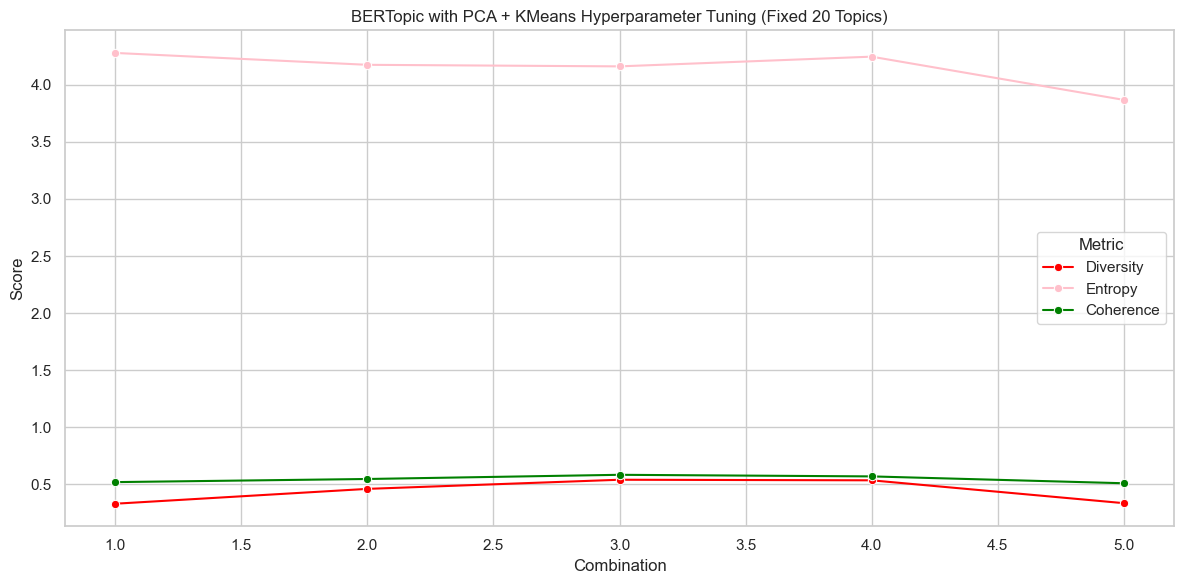

In [189]:
param_grid = [
    {'pca_n_components': 5, 'kmeans_n_clusters': 20, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'},
    {'pca_n_components': 10, 'kmeans_n_clusters': 25, 'kmeans_init': 'random', 'pca_svd_solver': 'full'},
    {'pca_n_components': 15, 'kmeans_n_clusters': 30, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'arpack'},
    {'pca_n_components': 20, 'kmeans_n_clusters': 20, 'kmeans_init': 'random', 'pca_svd_solver': 'randomized'},
    {'pca_n_components': 10, 'kmeans_n_clusters': 15, 'kmeans_init': 'k-means++', 'pca_svd_solver': 'auto'},]

results = []

for i, params in enumerate(param_grid):
    print(f"\nTuning BERTopic with PCA+KMeans - Combination {i+1}/{len(param_grid)}: {params}")

    topic_model = BERTopic(
        embedding_model=biobert_model,
        nr_topics=nr_topics,
        verbose=False,
        calculate_probabilities=True )
    
    topic_model.umap_model = PCA(n_components=params['pca_n_components'], svd_solver=params['pca_svd_solver'], random_state=42)
    topic_model.hdbscan_model = KMeans(n_clusters=params['kmeans_n_clusters'], init=params['kmeans_init'], random_state=42)
    
    topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)
    all_topics = topic_model.get_topics()
    topic_words = [[word for word, _ in all_topics[i]] for i in all_topics if i != -1]

    num_unassigned = sum(t == -1 for t in topics)
    pct_unassigned = num_unassigned / len(topics)

    diversity = len(set(sum(topic_words, []))) / (nr_topics * 10)
    entropy = topic_entropy(topics)
    coherence = compute_coherence(texts, topic_words)

    results.append({
        'Combination': i + 1,
        'Params': params,
        'Diversity': round(diversity, 4),
        'Entropy': round(entropy, 4),
        'Coherence': round(coherence, 4),
        'Unassigned Docs': num_unassigned,
        '% Unassigned': f"{pct_unassigned:.2%}" })

results_df = pd.DataFrame(results)

print("\n================ BERTopic with PCA+KMeans Tuning Results ================")
display(results_df)

# Plotting
plot_data = results_df.melt(
    id_vars='Combination',
    value_vars=['Diversity', 'Entropy', 'Coherence'],
    var_name='Metric')

custom_palette = {
    'Diversity': 'red',
    'Entropy': 'pink',
    'Coherence': 'green'}

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_data, x='Combination', y='value', hue='Metric', marker='o', palette=custom_palette)
plt.title("BERTopic with PCA + KMeans Hyperparameter Tuning (Fixed 20 Topics)")
plt.xlabel("Combination")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


Tuning BERTopic - Combination 1/5: {'umap_n_neighbors': 10, 'umap_n_components': 5, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10}

Tuning BERTopic - Combination 2/5: {'umap_n_neighbors': 15, 'umap_n_components': 5, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15}

Tuning BERTopic - Combination 3/5: {'umap_n_neighbors': 20, 'umap_n_components': 5, 'umap_min_dist': 0.2, 'hdbscan_min_cluster_size': 20}

Tuning BERTopic - Combination 4/5: {'umap_n_neighbors': 25, 'umap_n_components': 3, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15}

Tuning BERTopic - Combination 5/5: {'umap_n_neighbors': 15, 'umap_n_components': 3, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10}

================ BERTopic Hyperparameter Tuning Results ================


,Combination,Params,Diversity,Entropy,Coherence,Num Topics (excluding noise),Unassigned Docs,% Unassigned
0,1,"{'umap_n_neighbors': 10, 'umap_n_components': 5, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10}",0.745,2.781036,0.601301,19,7896,39.48%
1,2,"{'umap_n_neighbors': 15, 'umap_n_components': 5, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15}",0.730,3.327801,0.642992,19,7933,39.66%
2,3,"{'umap_n_neighbors': 20, 'umap_n_components': 5, 'umap_min_dist': 0.2, 'hdbscan_min_cluster_size': 20}",0.120,0.292789,0.463999,3,0,0.00%
3,4,"{'umap_n_neighbors': 25, 'umap_n_components': 3, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15}",0.770,3.582682,0.590060,19,8077,40.38%
4,5,"{'umap_n_neighbors': 15, 'umap_n_components': 3, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10}",0.820,2.751616,0.719943,19,6508,32.54%


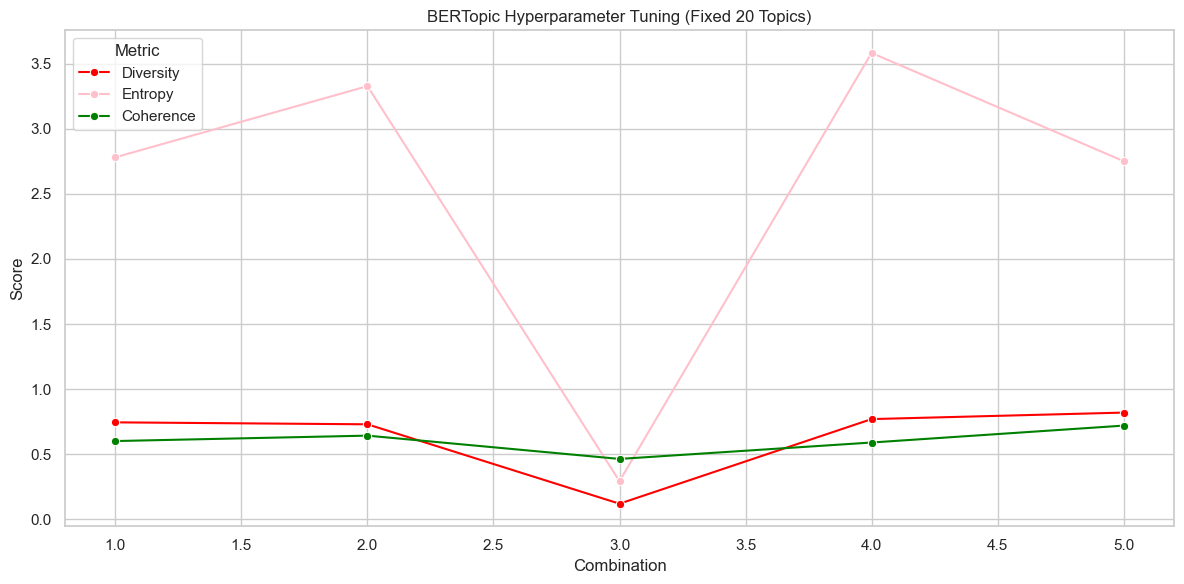

In [184]:
with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

from bertopic import BERTopic
bertopic_model = BERTopic.load("bertopic_biobert_model")

texts = (df['OBJECTIVE_BACKGROUND_clean'].fillna('') + ' ' + df['METHODS_clean'].fillna('')).tolist()

nr_topics = 20  

# === Hyperparameter grid ===
bertopic_param_grid = [
    {'umap_n_neighbors': 10, 'umap_n_components': 5, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10},
    {'umap_n_neighbors': 15, 'umap_n_components': 5, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15},
    {'umap_n_neighbors': 20, 'umap_n_components': 5, 'umap_min_dist': 0.2, 'hdbscan_min_cluster_size': 20},
    {'umap_n_neighbors': 25, 'umap_n_components': 3, 'umap_min_dist': 0.1, 'hdbscan_min_cluster_size': 15},
    {'umap_n_neighbors': 15, 'umap_n_components': 3, 'umap_min_dist': 0.05, 'hdbscan_min_cluster_size': 10},]

bertopic_results = []

for i, params in enumerate(bertopic_param_grid):
    print(f"\nTuning BERTopic - Combination {i+1}/{len(bertopic_param_grid)}: {params}")
    
    umap_model = umap.UMAP(
        n_neighbors=params['umap_n_neighbors'],
        n_components=params['umap_n_components'],
        min_dist=params['umap_min_dist'],
        metric='cosine',
        random_state=42)
    
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=params['hdbscan_min_cluster_size'],
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True)
    
    topic_model = BERTopic(
        embedding_model=biobert_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics=nr_topics,
        verbose=False)
    
    topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)
    all_topics = topic_model.get_topics()
    topic_words = [[word for word, _ in all_topics[i]] for i in all_topics if i != -1]


    
    num_unassigned = sum(t == -1 for t in topics)
    pct_unassigned = num_unassigned / len(topics)
    
    diversity = len(set(sum(topic_words, []))) / (nr_topics * 10)
    entropy = topic_entropy(topics)
    coherence = compute_coherence(texts, topic_words)
    
    bertopic_results.append({
        'Combination': i + 1,
        'Params': params,
        'Diversity': diversity,
        'Entropy': entropy,
        'Coherence': coherence,
        'Num Topics (excluding noise)': len(set(t for t in topics if t != -1)),
        'Unassigned Docs': num_unassigned,
        '% Unassigned': f"{pct_unassigned:.2%}"})

bertopic_results_df = pd.DataFrame(bertopic_results)

print("\n================ BERTopic Hyperparameter Tuning Results ================")
display(bertopic_results_df)

# Plotting metrics with custom colors
plot_data = bertopic_results_df.melt(
    id_vars='Combination',
    value_vars=['Diversity', 'Entropy', 'Coherence'],
    var_name='Metric')

custom_palette = {
    'Diversity': 'red',
    'Entropy': 'pink',
    'Coherence': 'green'}

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_data, x='Combination', y='value', hue='Metric', marker='o', palette=custom_palette)
plt.title("BERTopic Hyperparameter Tuning (Fixed 20 Topics)")
plt.xlabel("Combination")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()



Tuning LDA - Combination 1/4: {'max_df': 0.95, 'min_df': 3, 'learning_decay': 0.5}

Tuning LDA - Combination 2/4: {'max_df': 0.9, 'min_df': 5, 'learning_decay': 0.7}

Tuning LDA - Combination 3/4: {'max_df': 0.85, 'min_df': 2, 'learning_decay': 0.9}

Tuning LDA - Combination 4/4: {'max_df': 0.8, 'min_df': 4, 'learning_decay': 0.6}

============================== LDA TUNING RESULTS ==============================


,Combination,Params,Diversity,Entropy,Coherence,Unassigned Docs,% Unassigned
0,1,"{'learning_decay': 0.5, 'max_df': 0.95, 'min_df': 3}",0.760,3.656562,0.505623,0,0.00%
1,2,"{'learning_decay': 0.7, 'max_df': 0.9, 'min_df': 5}",0.665,3.846092,0.475002,0,0.00%
2,3,"{'learning_decay': 0.9, 'max_df': 0.85, 'min_df': 2}",0.770,3.189573,0.449070,0,0.00%
3,4,"{'learning_decay': 0.6, 'max_df': 0.8, 'min_df': 4}",0.760,3.627809,0.479102,0,0.00%


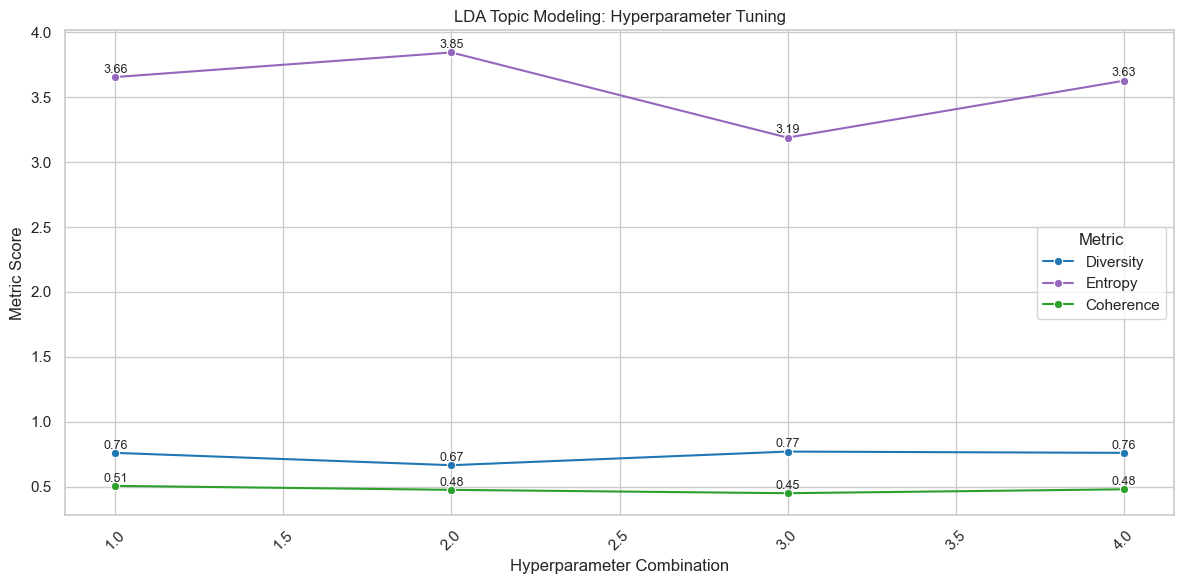

In [112]:
lda_param_grid = [
    {'max_df': 0.95, 'min_df': 3, 'learning_decay': 0.5},
    {'max_df': 0.90, 'min_df': 5, 'learning_decay': 0.7},
    {'max_df': 0.85, 'min_df': 2, 'learning_decay': 0.9},
    {'max_df': 0.80, 'min_df': 4, 'learning_decay': 0.6},]

lda_results = []
total_docs = len(texts)

for i, params in enumerate(lda_param_grid):
    print(f"\nTuning LDA - Combination {i+1}/{len(lda_param_grid)}: {params}")

    vectorizer = CountVectorizer(max_df=params['max_df'], min_df=params['min_df'], stop_words='english')
    X = vectorizer.fit_transform(texts)

    model = LatentDirichletAllocation(n_components=n_topics, max_iter=15, learning_method='online',learning_decay=params['learning_decay'], random_state=42)
    
    topic_distributions = model.fit_transform(X)
    labels = np.argmax(topic_distributions, axis=1)

    lda_unassigned = np.sum(topic_distributions.sum(axis=1) == 0)
    unassigned_pct = lda_unassigned / total_docs

    topic_words = [
        [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]] for topic in model.components_]

    diversity = topic_diversity(model, vectorizer)
    entropy = topic_entropy(labels)
    coherence = compute_coherence(texts, topic_words)

    lda_results.append({
        'Combination': i + 1,
        'Params': pprint.pformat(params),
        'Diversity': diversity,
        'Entropy': entropy,
        'Coherence': coherence,
        'Unassigned Docs': lda_unassigned,
        '% Unassigned': f"{unassigned_pct:.2%}"})

# === DISPLAY RESULTS ===
lda_results_df = pd.DataFrame(lda_results)
pd.set_option('display.max_colwidth', None)

print("\n============================== LDA TUNING RESULTS ==============================")
display(lda_results_df)

# === PLOT ===
plot_data_lda = lda_results_df.melt(
    id_vars='Combination',
    value_vars=['Diversity', 'Entropy', 'Coherence'],
    var_name='Metric')

custom_palette = {
    'Diversity': '#1f77b4', 'Entropy': '#9467bd', 'Coherence': '#2ca02c'}

plt.figure(figsize=(12, 6))
sns.lineplot( data=plot_data_lda, x='Combination', y='value', hue='Metric', palette=custom_palette, marker='o')

for metric in plot_data_lda['Metric'].unique():
    sub_df = plot_data_lda[plot_data_lda['Metric'] == metric]
    for _, row in sub_df.iterrows():
        plt.text(row['Combination'], row['value'] + 0.01, f"{row['value']:.2f}",
                 ha='center', va='bottom', fontsize=9)

plt.title("LDA Topic Modeling: Hyperparameter Tuning")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Metric Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Tuning NMF - Combination 1/12: {'max_df': 0.9, 'min_df': 3, 'alpha': 0.1, 'l1_ratio': 0.0}

Tuning NMF - Combination 2/12: {'max_df': 0.85, 'min_df': 5, 'alpha': 0.3, 'l1_ratio': 0.0}

Tuning NMF - Combination 3/12: {'max_df': 0.95, 'min_df': 2, 'alpha': 0.5, 'l1_ratio': 0.0}

Tuning NMF - Combination 4/12: {'max_df': 0.8, 'min_df': 4, 'alpha': 0.7, 'l1_ratio': 0.0}

Tuning NMF - Combination 5/12: {'max_df': 0.3, 'min_df': 4, 'alpha': 0.0, 'l1_ratio': 0.2}

Tuning NMF - Combination 6/12: {'max_df': 0.85, 'min_df': 5, 'alpha': 0.0, 'l1_ratio': 0.6}

Tuning NMF - Combination 7/12: {'max_df': 0.5, 'min_df': 3, 'alpha': 0.0, 'l1_ratio': 0.6}

Tuning NMF - Combination 8/12: {'max_df': 0.6, 'min_df': 2, 'alpha': 0.0, 'l1_ratio': 0.6}

Tuning NMF - Combination 9/12: {'max_df': 0.5, 'min_df': 3, 'alpha': 0.0, 'l1_ratio': 0.0}

Tuning NMF - Combination 10/12: {'max_df': 0.45, 'min_df': 4, 'alpha': 0.0, 'l1_ratio': 0.0}

Tuning NMF - Combination 11/12: {'max_df': 0.9, 'min_df': 3, 'alpha': 0.2,

,Combination,Params,Diversity,Entropy,Coherence,Unassigned Docs,% Unassigned
0,1,"{'alpha': 0.1, 'l1_ratio': 0.0, 'max_df': 0.9, 'min_df': 3}",0.055,-0.000000,0.368377,0,0.00%
1,2,"{'alpha': 0.3, 'l1_ratio': 0.0, 'max_df': 0.85, 'min_df': 5}",0.055,-0.000000,0.368377,0,0.00%
2,3,"{'alpha': 0.5, 'l1_ratio': 0.0, 'max_df': 0.95, 'min_df': 2}",0.055,-0.000000,0.368377,0,0.00%
3,4,"{'alpha': 0.7, 'l1_ratio': 0.0, 'max_df': 0.8, 'min_df': 4}",0.055,-0.000000,0.368377,0,0.00%
4,5,"{'alpha': 0.0, 'l1_ratio': 0.2, 'max_df': 0.3, 'min_df': 4}",0.910,4.167534,0.728508,0,0.00%
5,6,"{'alpha': 0.0, 'l1_ratio': 0.6, 'max_df': 0.85, 'min_df': 5}",0.875,4.222450,0.728656,0,0.00%
6,7,"{'alpha': 0.0, 'l1_ratio': 0.6, 'max_df': 0.5, 'min_df': 3}",0.890,4.186673,0.724342,0,0.00%
7,8,"{'alpha': 0.0, 'l1_ratio': 0.6, 'max_df': 0.6, 'min_df': 2}",0.900,4.186292,0.730739,0,0.00%
8,9,"{'alpha': 0.0, 'l1_ratio': 0.0, 'max_df': 0.5, 'min_df': 3}",0.890,4.186673,0.724342,0,0.00%
9,10,"{'alpha': 0.0, 'l1_ratio': 0.0, 'max_df': 0.45, 'min_df': 4}",0.895,4.217447,0.747804,0,0.00%


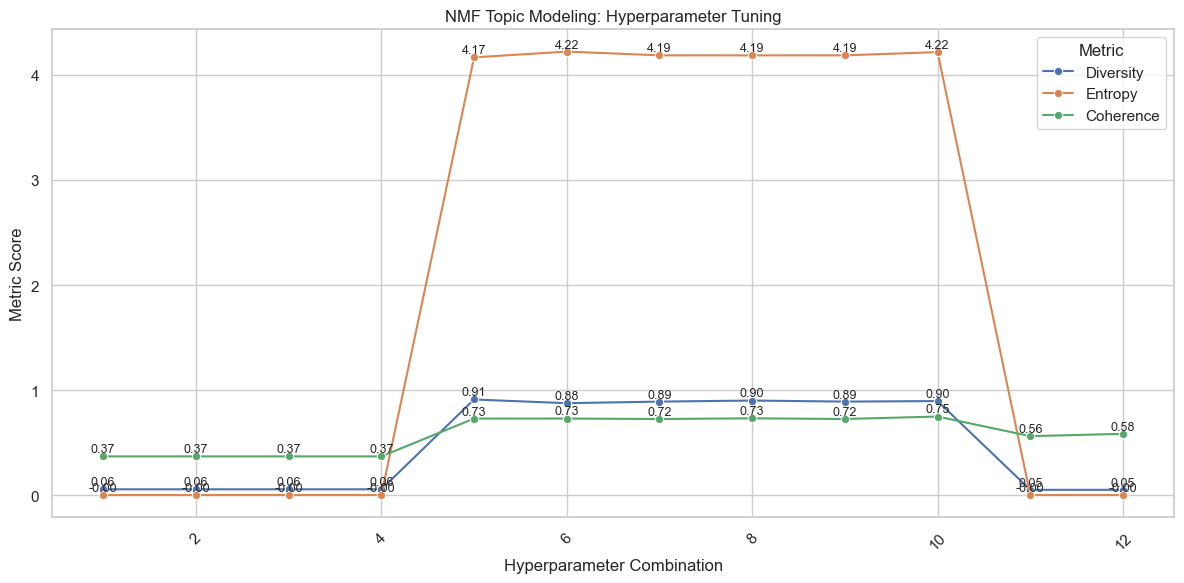

In [107]:
# === PARAMETERS ===
param_grid = [
    # 4 combos: l1_ratio=0, varying alpha
    {'max_df': 0.9,  'min_df': 3,  'alpha': 0.1, 'l1_ratio': 0.0},
    {'max_df': 0.85, 'min_df': 5,  'alpha': 0.3, 'l1_ratio': 0.0},
    {'max_df': 0.95, 'min_df': 2,  'alpha': 0.5, 'l1_ratio': 0.0},
    {'max_df': 0.8,  'min_df': 4,  'alpha': 0.7, 'l1_ratio': 0.0},

    # 4 combos: alpha=0, varying l1_ratio
    {'max_df': 0.30, 'min_df': 4,  'alpha': 0.0, 'l1_ratio': 0.2},
    {'max_df': 0.85, 'min_df': 5,  'alpha': 0.0, 'l1_ratio': 0.6},
    {'max_df': 0.50, 'min_df': 3,  'alpha': 0.0, 'l1_ratio': 0.6},
    {'max_df': 0.60, 'min_df': 2,  'alpha': 0.0, 'l1_ratio': 0.6},

    # 2 combos: alpha=0, l1_ratio=0 (no regularization)
    {'max_df': 0.50, 'min_df': 3,  'alpha': 0.0, 'l1_ratio': 0.0},
    {'max_df': 0.45, 'min_df': 4,  'alpha': 0.0, 'l1_ratio': 0.0},

    # 2 combos: normal alpha and l1_ratio
    {'max_df': 0.9,  'min_df': 3,  'alpha': 0.2, 'l1_ratio': 0.3},
    {'max_df': 0.85, 'min_df': 5,  'alpha': 0.4, 'l1_ratio': 0.5},]

# === HYPERPARAMETER TUNING LOOP ===
nmf_results = []
total_docs = len(texts)

for i, params in enumerate(param_grid):
    print(f"\nTuning NMF - Combination {i+1}/{len(param_grid)}: {params}")
    
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'], stop_words='english')
    X = vectorizer.fit_transform(texts)

    model = NMF(n_components=n_topics, random_state=42, max_iter=200,
                alpha_W=params['alpha'], alpha_H=params['alpha'], l1_ratio=params['l1_ratio'])

    W = model.fit_transform(X)
    labels = np.argmax(W, axis=1)

    nmf_unassigned = np.sum(W.sum(axis=1) == 0)
    unassigned_pct = nmf_unassigned / total_docs

    topic_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]for topic in model.components_]

    diversity = topic_diversity(model, vectorizer)
    entropy = topic_entropy(labels)
    coherence = compute_coherence(texts, topic_words)

    nmf_results.append({
        'Combination': i + 1,
        'Params': pprint.pformat(params),
        'Diversity': diversity,
        'Entropy': entropy,
        'Coherence': coherence,
        'Unassigned Docs': nmf_unassigned,
        '% Unassigned': f"{unassigned_pct:.2%}" })

# === DISPLAY RESULTS ===
nmf_results_df = pd.DataFrame(nmf_results)
pd.set_option('display.max_colwidth', None)

print("\n============================== NMF TUNING RESULTS ==============================")
display(nmf_results_df)

# === PLOT ===
plot_data = nmf_results_df.melt(
    id_vars='Combination',
    value_vars=['Diversity', 'Entropy', 'Coherence'],
    var_name='Metric')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='Combination', y='value', hue='Metric', marker='o')

for metric in plot_data['Metric'].unique():
    sub_df = plot_data[plot_data['Metric'] == metric]
    for _, row in sub_df.iterrows():
        plt.text(row['Combination'], row['value'] + 0.01, f"{row['value']:.2f}",
                 ha='center', va='bottom', fontsize=9)

plt.title("NMF Topic Modeling: Hyperparameter Tuning")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Metric Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Final NMF Metrics → Diversity: 0.895 | Entropy: 4.217 | Coherence: 0.748


,Model,Topic ID,Topic Name,Top Words,Doc Count
0,NMF (Final),0,controlled practice,"controlled, quality, practice, hospital, trial, primary, health, cost, outcome, care",445
1,NMF (Final),1,lidocaine intensity,"lidocaine, analog, intensity, va, score, injection, analgesic, visual, scale, pain",1035
2,NMF (Final),2,placebocontrolled doubleblind,"placebocontrolled, phase, therapy, doubleblind, daily, safety, placebo, efficacy, treatment, week",1644
3,NMF (Final),3,concentration crossover,"single, test, effect, crossover, volunteer, plasma, concentration, dose, healthy, subject",1339
4,NMF (Final),4,infarction myocardial,"bypass, acute, stroke, disease, pci, stent, artery, infarction, myocardial, coronary",1104
5,NMF (Final),5,acupuncture treatment,"effect, acupuncture, randomly, received, divided, treatment, treated, case, control, group",2168
6,NMF (Final),6,chemotherapy advanced,"tumor, stage, arm, advanced, cycle, breast, survival, mgm, chemotherapy, cancer",729
7,NMF (Final),7,rehabilitation strength,"aerobic, test, rehabilitation, week, strength, program, muscle, physical, training, exercise",708
8,NMF (Final),8,postoperative anaesthesia,"block, epidural, anaesthesia, infusion, analgesia, propofol, undergoing, postoperative, anesthesia, surgery",1012
9,NMF (Final),9,metformin glycemic,"glycemic, diabetic, hbac, fasting, mellitus, metformin, type, glucose, diabetes, insulin",670


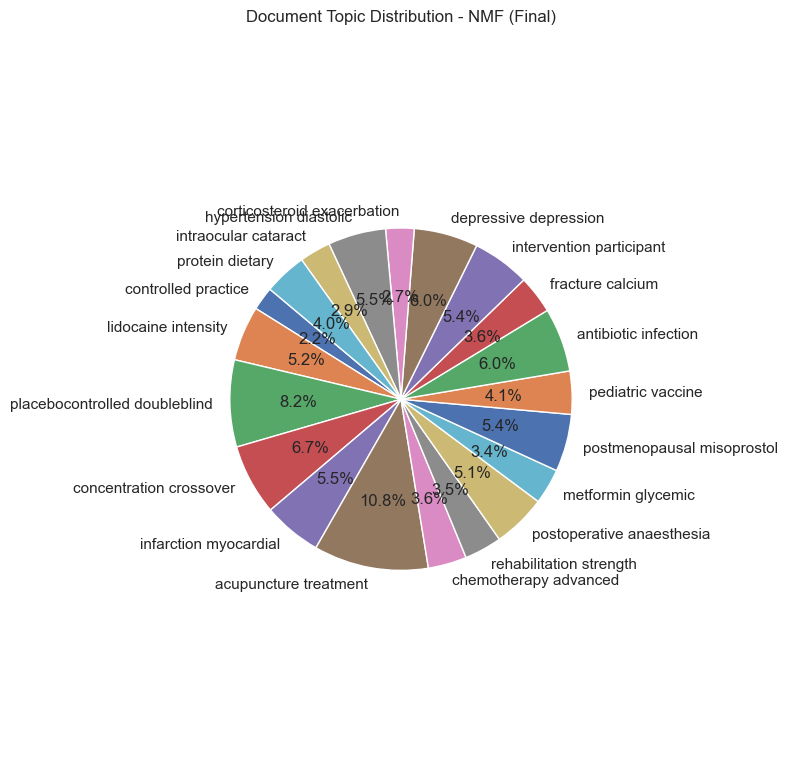

In [111]:
# === BEST PARAMETERS (from Combination 10) ===
best_params = {'alpha': 0.0, 'l1_ratio': 0.0, 'max_df': 0.45, 'min_df': 4}
n_topics = 20  

# === TF-IDF VECTORIZATION ===
vectorizer_final = TfidfVectorizer(max_df=best_params['max_df'], min_df=best_params['min_df'], stop_words='english')
X_final = vectorizer_final.fit_transform(texts)

# === FINAL NMF MODEL ===
nmf_final = NMF(n_components=n_topics, random_state=42, max_iter=200,
                alpha_W=best_params['alpha'],
                alpha_H=best_params['alpha'],
                l1_ratio=best_params['l1_ratio'])

W_final = nmf_final.fit_transform(X_final)
nmf_labels = np.argmax(W_final, axis=1)

# === TOP WORDS PER TOPIC ===
nmf_words = [
    [vectorizer_final.get_feature_names_out()[i] for i in topic.argsort()[-10:]]for topic in nmf_final.components_]

# === Generate meaningful topic names using your function ===
nmf_names = auto_name_all_topics(nmf_words)

# === Map numeric topic IDs to meaningful names ===
topic_id_to_name = {i: name for i, name in enumerate(nmf_names)}

# === Assign meaningful topic names to dataframe ===
df['topic'] = [topic_id_to_name[label] for label in nmf_labels]

# === METRICS ===
diversity = topic_diversity(nmf_final, vectorizer_final)
entropy = topic_entropy(nmf_labels)
coherence = compute_coherence(texts, nmf_words)

print(f"\nFinal NMF Metrics → Diversity: {diversity:.3f} | Entropy: {entropy:.3f} | Coherence: {coherence:.3f}")

# === SUMMARY & PLOT ===
nmf_df = topic_summary_df(nmf_labels, nmf_words, nmf_names, "NMF (Final)")
display(nmf_df)

plot_topic_distribution_pie(nmf_df, "NMF (Final)")


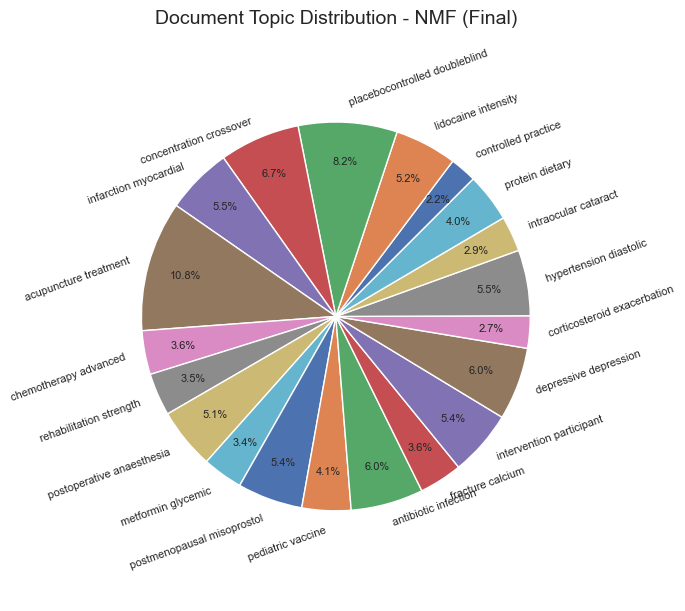

In [127]:
def plot_topic_distribution_pie_with_tilt(df, model_name):
    import matplotlib.pyplot as plt
    import numpy as np

    model_df = df[df["Model"] == model_name]
    labels = model_df["Topic Name"]
    sizes = model_df["Doc Count"]

    plt.figure(figsize=(7, 7))
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=45,
        textprops={'fontsize': 8, 'rotation_mode': 'anchor'},
        pctdistance=0.8)

    for text in texts:
        angle = text.get_rotation()
        text.set_rotation(angle + 20)
    
    plt.axis('equal') 
    plt.title(f"Document Topic Distribution - {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
plot_topic_distribution_pie_with_tilt(nmf_df, "NMF (Final)")


## Task 2 - Sentiment Analysis

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          20000 non-null  object 
 1   OBJECTIVE_BACKGROUND        20000 non-null  object 
 2   METHODS                     20000 non-null  object 
 3   RESULTS_CONCLUSIONS         20000 non-null  object 
 4   research_intents            20000 non-null  object 
 5   intent_combo                20000 non-null  object 
 6   vader_class                 20000 non-null  object 
 7   combined_text               20000 non-null  object 
 8   combined_wordcount          20000 non-null  int64  
 9   combined_flesch             20000 non-null  float64
 10  Objective_vs_Methods        20000 non-null  float64
 11  Methods_vs_Results          20000 non-null  float64
 12  Objective_vs_Results        20000 non-null  float64
 13  OBJECTIVE_BACKGROUND_clean  200

In [138]:
texts = df['RESULTS_CONCLUSIONS_clean'].tolist()

# VADER
sid = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# TextBlob
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

# SentiWordNet helper functions
from nltk.corpus import wordnet

def penn_to_wn(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('R'):
        return wordnet.ADV
    return None

def sentiwordnet_sentiment(text):
    from nltk import word_tokenize, pos_tag
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    
    scores = []
    for word, tag in pos_tags:
        wn_tag = penn_to_wn(tag)
        if not wn_tag:
            continue
        synsets = list(swn.senti_synsets(word, wn_tag))
        if not synsets:
            continue
        synset_scores = [(s.pos_score() - s.neg_score()) for s in synsets]
        if synset_scores:
            scores.append(np.mean(synset_scores))
    if not scores:
        return "Neutral"
    avg_score = np.mean(scores)
    if avg_score > 0.05:
        return "Positive"
    elif avg_score < -0.05:
        return "Negative"
    else:
        return "Neutral"

### Applying methods to get sentiment labels
df['VADER_Sentiment'] = df['RESULTS_CONCLUSIONS_clean'].apply(vader_sentiment)
df['TextBlob_Sentiment'] = df['RESULTS_CONCLUSIONS_clean'].apply(textblob_sentiment)
df['SentiWordNet_Sentiment'] = df['RESULTS_CONCLUSIONS_clean'].apply(sentiwordnet_sentiment)


In [209]:
label_encoding = {'Negative':0, 'Neutral':1, 'Positive':2}

# embedder = SentenceTransformer('all-MiniLM-L6-v2')
# embeddings = embedder.encode(texts, show_progress_bar=True)

# np.save('sentiment_embeddings.npy', embeddings)
embeddings = np.load('sentiment_embeddings.npy')

def compute_perplexity(texts, sentiments):
   sentiment_texts = {}
   for text, sent in zip(texts, sentiments):
       if sent not in sentiment_texts:
           sentiment_texts[sent] = []
       sentiment_texts[sent].append(text)
   
   perplexities = []
   for sent_group in sentiment_texts.values():
       if len(sent_group) > 5:
           vectorizer = CountVectorizer(stop_words='english', max_features=100)
           X = vectorizer.fit_transform(sent_group)
           lda = LatentDirichletAllocation(n_components=2, max_iter=10, random_state=42)
           lda.fit(X)
           perplexities.append(lda.perplexity(X))
   return np.mean(perplexities) if perplexities else np.nan

def compute_coherence(texts, sentiments, target_sentiment):
   filtered_texts = [t for t, s in zip(texts, sentiments) if s == target_sentiment]
   if len(filtered_texts) < 10:
       return np.nan
   
   tokenized_texts = [nltk.word_tokenize(doc.lower()) for doc in filtered_texts]
   dictionary = Dictionary(tokenized_texts)
   corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
   
   lda = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=1, random_state=42)
   cm = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
   return cm.get_coherence()
    


In [141]:
from gensim.models.ldamodel import LdaModel
results = []
for method in ['VADER_Sentiment', 'TextBlob_Sentiment', 'SentiWordNet_Sentiment']:
   sentiments = df[method].tolist()
   
   perp = compute_perplexity(texts, sentiments)
   
   numeric_labels = [label_encoding.get(s, -1) for s in sentiments]
   valid_idx = [i for i, lbl in enumerate(numeric_labels) if lbl != -1]
   valid_labels = [numeric_labels[i] for i in valid_idx]
   valid_embeddings = embeddings[valid_idx]
   
   if len(set(valid_labels)) > 1:
       sil = silhouette_score(valid_embeddings, valid_labels)
       sil_samples = silhouette_samples(valid_embeddings, valid_labels)
       borderline_mask = (sil_samples > -0.1) & (sil_samples < 0.1)
       borderline_pct = np.sum(borderline_mask) / len(valid_labels) * 100
       negative_pct = np.sum(sil_samples < 0) / len(valid_labels) * 100
   else:
       sil = np.nan
       borderline_pct = 0
       negative_pct = 0
   
   coherences = []
   for sentiment_label in ['Positive', 'Neutral', 'Negative']:
       coh = compute_coherence(texts, sentiments, sentiment_label)
       if not np.isnan(coh):
           coherences.append(coh)
   avg_coh = np.mean(coherences) if coherences else np.nan
   
   results.append({
       'Method': method.replace('_Sentiment', ''),
       'Perplexity': round(perp, 3),
       'Coherence Score': round(avg_coh, 3),
       'Silhouette Score': round(sil, 3) if not np.isnan(sil) else 'N/A',
       '% Borderline Silhouette': f"{borderline_pct:.1f}%",
       '% Negative Silhouette': f"{negative_pct:.1f}%"})

results_df = pd.DataFrame(results)
display(results_df)

,Method,Perplexity,Coherence Score,Silhouette Score,% Borderline Silhouette,% Negative Silhouette
0,VADER,69.324,0.361,0.005,100.0%,27.4%
1,TextBlob,71.130,0.313,-0.001,100.0%,57.0%
2,SentiWordNet,69.460,0.321,0.001,100.0%,43.3%


In [142]:
results_df = pd.DataFrame(results)
display(results_df.drop(columns=['% Borderline Silhouette', 'Silhouette Score']))


,Method,Perplexity,Coherence Score,% Negative Silhouette
0,VADER,69.324,0.361,27.4%
1,TextBlob,71.130,0.313,57.0%
2,SentiWordNet,69.460,0.321,43.3%


In [143]:
df.rename(columns={'VADER_Sentiment': 'sentiments'}, inplace=True)

## Final Results

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          20000 non-null  object 
 1   OBJECTIVE_BACKGROUND        20000 non-null  object 
 2   METHODS                     20000 non-null  object 
 3   RESULTS_CONCLUSIONS         20000 non-null  object 
 4   research_intents            20000 non-null  object 
 5   intent_combo                20000 non-null  object 
 6   vader_class                 20000 non-null  object 
 7   combined_text               20000 non-null  object 
 8   combined_wordcount          20000 non-null  int64  
 9   combined_flesch             20000 non-null  float64
 10  Objective_vs_Methods        20000 non-null  float64
 11  Methods_vs_Results          20000 non-null  float64
 12  Objective_vs_Results        20000 non-null  float64
 13  OBJECTIVE_BACKGROUND_clean  200

In [160]:
df['topic'] = df['topic'].astype(str)
df['sentiments'] = df['sentiments'].astype(str)


In [166]:
print(df['topic'].value_counts())
print(df['sentiments'].value_counts())


topic
acupuncture treatment            2168
placebocontrolled doubleblind    1644
concentration crossover          1339
depressive depression            1209
antibiotic infection             1207
infarction myocardial            1104
hypertension diastolic           1093
intervention participant         1089
postmenopausal misoprostol       1084
lidocaine intensity              1035
postoperative anaesthesia        1012
pediatric vaccine                 814
protein dietary                   807
chemotherapy advanced             729
fracture calcium                  717
rehabilitation strength           708
metformin glycemic                670
intraocular cataract              589
corticosteroid exacerbation       537
controlled practice               445
Name: count, dtype: int64
sentiments
Positive    14551
Negative     4928
Neutral       521
Name: count, dtype: int64


In [161]:
df[['topic', 'sentiments']]

,topic,sentiments
0,concentration crossover,Positive
1,postoperative anaesthesia,Negative
2,postmenopausal misoprostol,Negative
3,corticosteroid exacerbation,Neutral
4,hypertension diastolic,Positive
...,...,...
19995,corticosteroid exacerbation,Positive
19996,intervention participant,Positive
19997,intervention participant,Negative
19998,postoperative anaesthesia,Positive


In [163]:
print(df[['topic', 'sentiments']].dtypes)
print(df['topic'].head(10).tolist())
print(df['sentiments'].head(10).tolist())


topic         object
sentiments    object
dtype: object
['concentration crossover', 'postoperative anaesthesia', 'postmenopausal misoprostol', 'corticosteroid exacerbation', 'hypertension diastolic', 'infarction myocardial', 'intraocular cataract', 'intraocular cataract', 'postmenopausal misoprostol', 'postoperative anaesthesia']
['Positive', 'Negative', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral']


In [178]:
results = []
for topic in df['topic'].unique():
    topic_data = df[df['topic'] == topic]
    total = len(topic_data)

    positive = len(topic_data[topic_data['sentiments'] == 'Positive'])
    negative = len(topic_data[topic_data['sentiments'] == 'Negative'])
    neutral = len(topic_data[topic_data['sentiments'] == 'Neutral'])

    positive_pct = (positive / total) * 100 if total > 0 else 0
    negative_pct = (negative / total) * 100 if total > 0 else 0
    neutral_pct = (neutral / total) * 100 if total > 0 else 0

    results.append({
        'topic': topic,
        'Total': total,
        'Positive %': round(positive_pct, 2),
        'Negative %': round(negative_pct, 2),
        'Neutral %': round(neutral_pct, 2), })


topic_sentiment_percentages = pd.DataFrame(results)
topic_sentiment_percentages = topic_sentiment_percentages.sort_values('Positive %', ascending=False)

display(topic_sentiment_percentages) 


,topic,Total,Positive %,Negative %,Neutral %
14,rehabilitation strength,708,89.12,9.04,1.84
3,corticosteroid exacerbation,537,85.85,12.85,1.30
16,metformin glycemic,670,81.19,16.12,2.69
18,controlled practice,445,80.90,16.85,2.25
0,concentration crossover,1339,79.69,16.95,3.36
6,intraocular cataract,589,79.12,18.51,2.38
12,placebocontrolled doubleblind,1644,78.83,18.67,2.49
17,intervention participant,1089,78.05,19.38,2.57
11,protein dietary,807,77.32,20.94,1.73
19,fracture calcium,717,77.13,20.64,2.23


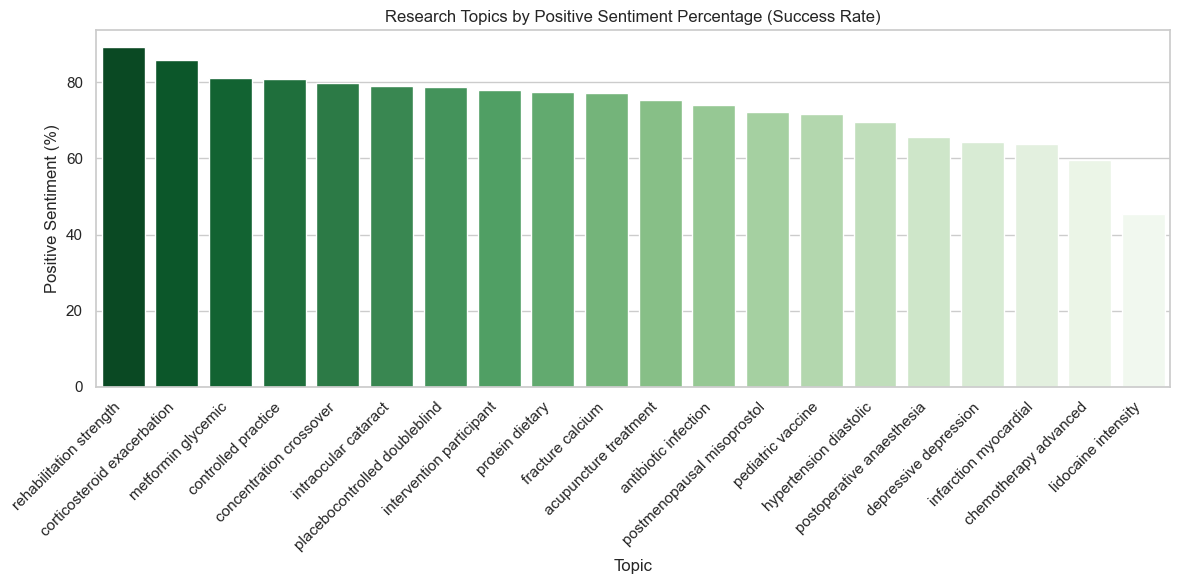

In [172]:
top_10 = topic_sentiment_counts.head(20).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=top_10, x='topic', y='Positive %', palette='Greens_r')
plt.xticks(rotation=45, ha='right')
plt.title("Research Topics by Positive Sentiment Percentage (Success Rate)")
plt.ylabel("Positive Sentiment (%)")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()


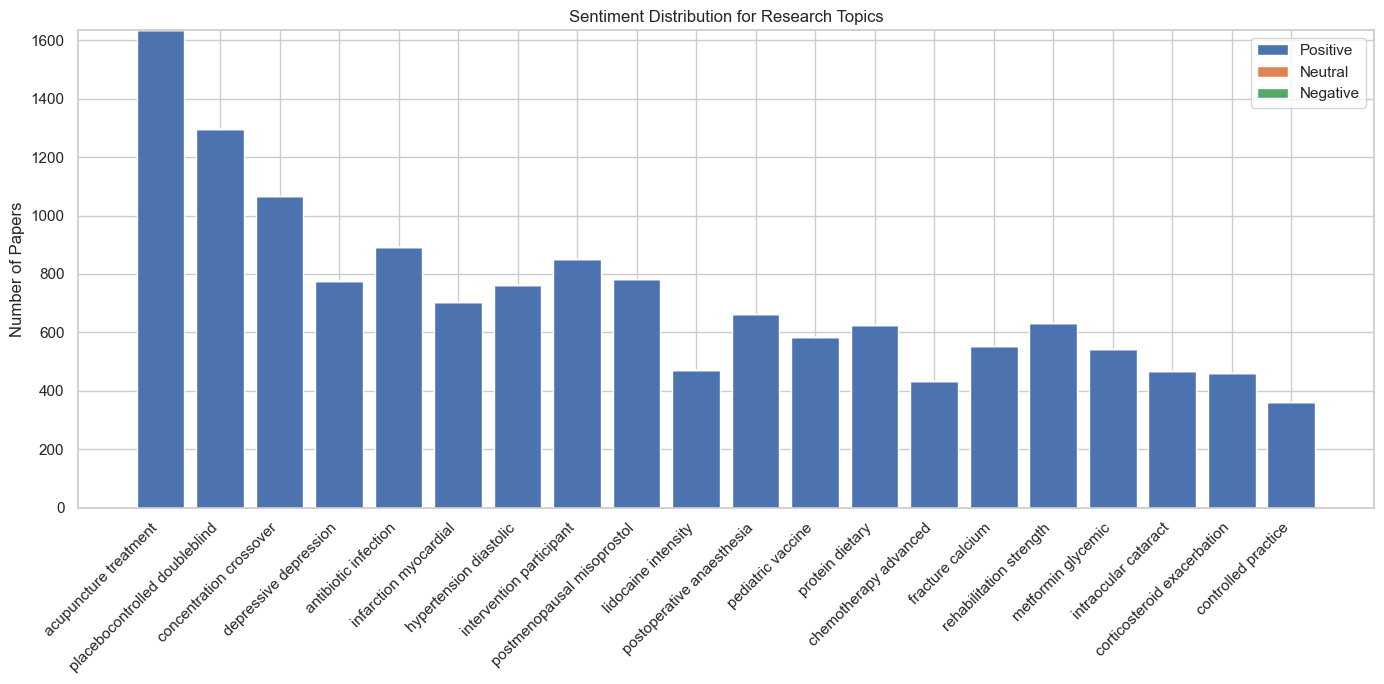

In [174]:
top_topics_by_count = topic_sentiment_counts.sort_values('Total', ascending=False).head(20)
top_topics_by_count = top_topics_by_count.reset_index()

sentiment_cols = ['Positive', 'Neutral', 'Negative']
for col in sentiment_cols:
    if col not in top_topics_by_count.columns:
        top_topics_by_count[col] = 0

plt.figure(figsize=(14,7))
bottom_vals = np.zeros(len(top_topics_by_count))

for sentiment in sentiment_cols:
    plt.bar(top_topics_by_count['topic'], top_topics_by_count[sentiment], bottom=bottom_vals, label=sentiment)
    bottom_vals += top_topics_by_count[sentiment].values

plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Papers")
plt.title("Sentiment Distribution for Research Topics")
plt.legend()
plt.tight_layout()
plt.show()


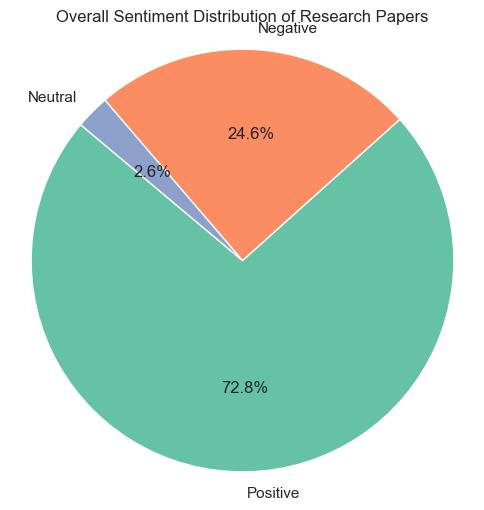

In [175]:
overall_counts = df['sentiments'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5','#fc8d62','#8da0cb'])
plt.title("Overall Sentiment Distribution of Research Papers")
plt.axis('equal')
plt.show()


## Application on an Unseen Data

In [191]:
def parse_research_abstracts(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
   
    abstracts = re.split(r'###(\d+)', content)

    if abstracts[0].strip() == '':
        abstracts = abstracts[1:]
    data = []

    for i in range(0, len(abstracts), 2):
        if i + 1 < len(abstracts):
            research_id = abstracts[i].strip()
            abstract_text = abstracts[i + 1].strip()
            sections = defaultdict(list)
            lines = abstract_text.split('\n')
            current_section = None
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                section_match = re.match(r'^(BACKGROUND|OBJECTIVE|METHODS?|RESULTS?|CONCLUSIONS?)\s+(.+)', line)
                if section_match:
                    current_section = section_match.group(1)
                    # Normalizing section names
                    if current_section in ['METHOD', 'METHODS']:
                        current_section = 'METHODS'
                    elif current_section in ['RESULT', 'RESULTS']:
                        current_section = 'RESULTS'
                    elif current_section in ['CONCLUSION', 'CONCLUSIONS']:
                        current_section = 'CONCLUSIONS'
                    
                    sections[current_section].append(section_match.group(2))
                elif current_section:
                    sections[current_section].append(line)
            
            row_data = {'ID': research_id}
            for section, texts in sections.items():
                row_data[section] = ' '.join(texts)
            
            # Ensuring all possible columns exist (fill with empty string if missing)
            for col in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']:
                if col not in row_data:
                    row_data[col] = ''
            
            data.append(row_data)

    df = pd.DataFrame(data)
    
    # Reordering columns
    column_order = ['ID', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']
    df = df.reindex(columns=column_order)
    return df

if __name__ == "__main__":
    df_unseen = parse_research_abstracts('C://Users//Sakshi Vishwakarma//Downloads//data//test.txt')
    df_unseen = df_unseen.sample(n=2000, random_state=42)

In [195]:
df_unseen['OBJECTIVE_BACKGROUND'] = (df_unseen['OBJECTIVE'].fillna('') + ' ' + df_unseen['BACKGROUND'].fillna('')).str.strip()
df_unseen['RESULTS_CONCLUSIONS'] = (df_unseen['RESULTS'].fillna('') + ' ' + df_unseen['CONCLUSIONS'].fillna('')).str.strip()
df_unseen = df_unseen[['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']]

In [196]:
df_unseen.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
1447,9924327,"To compare the tolerability and efficacy of a fixed combination solution of dorzolamide/timolol ( Cosopt ) , administered twice daily with the concomitant administration of its components , dorzolamide ( Trusopt ) twice daily and timolol ( Timoptic ) twice daily .","After a 2 week timolol run in , patients with open angle glaucoma or ocular hypertension were randomised ( 1:1 ) to receive treatment with either the dorzolamide/timolol combination solution twice daily ( combination ) or the dorzolamide solution twice daily plus timolol maleate solution twice daily ( concomitant ) for 3 months .","299 patients were entered and 290 patients completed the study . Compared with the timolol baseline , additional IOP lowering of 16 % was observed at trough ( hour 0 ) and 22 % at peak ( hour 2 ) at month 3 in both the concomitant and combination groups . The IOP lowering effects of the two treatment groups were clinically and statistically equivalent as demonstrated by the extremely small point differences ( concomitant -- combination ) observed in this study -- 0.01 mm Hg at trough and 0.08 mm Hg at peak . The safety variables of the concomitant and combination groups were very similar . Both combination and concomitant therapy were well tolerated and few patients discontinued due to adverse effects . The dorzolamide/timolol combination solution administered twice daily is equivalent in efficacy and has a similar safety profile to the concomitant administration of the components administered twice daily ."
1114,19910834,This study was designed to evaluate the effects of total enteral nutrition and total parenteral nutrition in prevention of pancreatic necrotic infection in severe acute pancreatitis .,"One hundred seven patients were enrolled in the study between 2003 and 2007 . In the first week of hospitalization , they were randomized to feeding by either total parenteral nutrition ( 54 patients ) or total enteral nutrition ( 53 patients ) . All patients were concomitantly administered with sufficient prophylactic antibiotics . Computed tomographic scan and C-reactive protein level indicated a similar clinical severity in both groups .","Eighty percent of the patients developed organ failure in the group with total parenteral nutrition , which was higher than that in the group with total enteral nutrition ( 21 % ) . Eighty percent and 22 % ( P < 0.05 ) of the patients in the total parenteral nutrition and total enteral nutrition groups , respectively , underwent surgical intervention . The incidence of pancreatic septic necroses in the group with total enteral nutrition ( 23 % ) was lower than that in the group with total parenteral nutrition ( 72 % , P < 0.05 ) . Mortality in the total parenteral nutrition group ( 43 % ) was higher than in the total enteral nutrition group ( 11 % , P < 0.05 ) . Total enteral nutrition is better than total parenteral nutrition in the prevention of pancreatic necrotic infection in severe acute pancreatitis ."
1064,23558840,"The pattern and magnitude of the hyperglycemic response to surgical stress , the added effect of low-dose steroids , and whether these differ in diabetics and nondiabetics remain unclear . We therefore tested 2 hypotheses : ( 1 ) that diabetics show a greater increase from preoperative to intraoperative glucose concentrations than nondiabetics ; and ( 2 ) that steroid administration increases intraoperative hyperglycemia more so in diabetics compared with nondiabetics .","Patients scheduled for major noncardiac surgery under general anesthesia were enrolled and randomized to preoperative IV 8 mg dexamethasone or placebo , stratified by diagnosis of diabetes . Patients were part of a larger underlying trial ( the Dexamethasone , Light Anesthesia and Tight Glucose Control [ DeLiT ] Trial ) . IV insulin was given when glucose concentration exceeded 215 mg/dL . The primary outcome measure was the change in glucose from 

In [197]:
print("Loading and preparing data...")

def preprocess_text(text):
    """Complete text preprocessing pipeline"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+[\.\d]*', '', text) 
    text = re.sub(r'[+\-*/=<>(){}[\]%]', '', text) 
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Applying preprocessing to all sections
print("Preprocessing text sections...")
df_unseen['OBJECTIVE_BACKGROUND_clean'] = df_unseen['OBJECTIVE_BACKGROUND'].apply(preprocess_text)
df_unseen['METHODS_clean'] = df_unseen['METHODS'].apply(preprocess_text)
df_unseen['RESULTS_CONCLUSIONS_clean'] = df_unseen['RESULTS_CONCLUSIONS'].apply(preprocess_text)

# Creating combined text for overall analysis
df_unseen['full_text_clean'] = (df_unseen['OBJECTIVE_BACKGROUND_clean'] + ' ' + df_unseen['METHODS_clean'] + ' ' + df_unseen['RESULTS_CONCLUSIONS_clean']).str.strip()
df_unseen = df_unseen[df_unseen['full_text_clean'].str.len() > 10].reset_index(drop=True)
print(f"Data shape after preprocessing: {df_unseen.shape}")


Loading and preparing data...
Preprocessing text sections...
Data shape after preprocessing: (2000, 8)



Final NMF Metrics → Diversity: 0.880 | Entropy: 4.199 | Coherence: 0.639


,Model,Topic ID,Topic Name,Top Words,Doc Count
0,NMF (Final),0,placebocontrolled doubleblind,"placebocontrolled, phase, primary, daily, treatment, doubleblind, placebo, safety, efficacy, week",66
1,NMF (Final),1,treatment clinical,"effect, clinical, received, randomly, divided, treatment, treated, control, case, group",182
2,NMF (Final),2,intervention participant,"participant, controlled, trial, program, practice, primary, usual, health, care, intervention",169
3,NMF (Final),3,metformin glycemic,"glycemic, plasma, mgdl, fasting, diabetic, metformin, type, diabetes, insulin, glucose",87
4,NMF (Final),4,chemotherapy cisplatin,"advanced, cycle, cisplatin, stage, plus, survival, breast, mgm, chemotherapy, cancer",109
5,NMF (Final),5,association ventricular,"association, chronic, fraction, ejection, cardiac, left, ventricular, therapy, failure, heart",59
6,NMF (Final),6,concentration crossover,"dose, acid, crossover, volunteer, effect, concentration, plasma, diet, healthy, subject",131
7,NMF (Final),7,postoperative bupivacaine,"block, analgesic, scale, visual, bupivacaine, analgesia, surgery, anesthesia, postoperative, pain",102
8,NMF (Final),8,participant resistance,"participant, fall, strength, physical, resistance, aerobic, week, muscle, training, exercise",60
9,NMF (Final),9,osteoporosis fracture,"year, osteoporosis, sinus, fracture, month, mineral, density, bmd, implant, bone",50


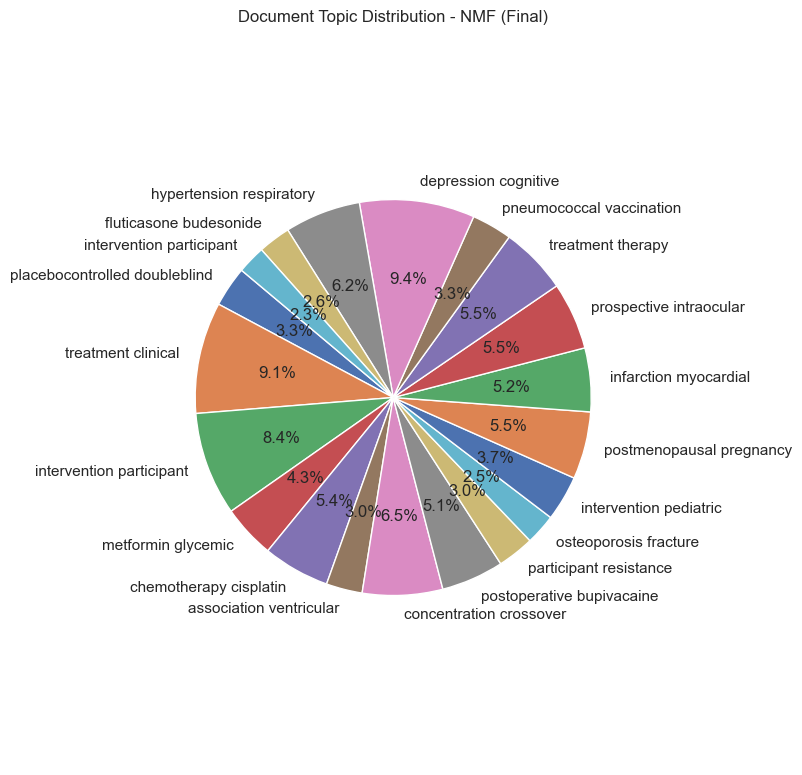

In [201]:
texts = (df_unseen['OBJECTIVE_BACKGROUND_clean'].fillna('') + ' ' + df_unseen['METHODS_clean'].fillna('')).tolist()
n_topics = 20

# === BEST PARAMETERS (from Combination 10) ===
best_params = {'alpha': 0.0, 'l1_ratio': 0.0, 'max_df': 0.45, 'min_df': 4}
n_topics = 20  

# === TF-IDF VECTORIZATION ===
vectorizer_final = TfidfVectorizer(max_df=best_params['max_df'], min_df=best_params['min_df'], stop_words='english')
X_final = vectorizer_final.fit_transform(texts)

# === FINAL NMF MODEL ===
nmf_final = NMF(n_components=n_topics, random_state=42, max_iter=200,
                alpha_W=best_params['alpha'],
                alpha_H=best_params['alpha'],
                l1_ratio=best_params['l1_ratio'])

W_final = nmf_final.fit_transform(X_final)
nmf_labels = np.argmax(W_final, axis=1)

# === TOP WORDS PER TOPIC ===
nmf_words = [
    [vectorizer_final.get_feature_names_out()[i] for i in topic.argsort()[-10:]]for topic in nmf_final.components_]

# === Generate meaningful topic names using your function ===
nmf_names = auto_name_all_topics(nmf_words)

# === Map numeric topic IDs to meaningful names ===
topic_id_to_name = {i: name for i, name in enumerate(nmf_names)}

# === Assign meaningful topic names to dataframe ===
df_unseen['topic'] = [topic_id_to_name[label] for label in nmf_labels]

# === METRICS ===
diversity = topic_diversity(nmf_final, vectorizer_final)
entropy = topic_entropy(nmf_labels)
coherence = compute_coherence(texts, nmf_words)

print(f"\nFinal NMF Metrics → Diversity: {diversity:.3f} | Entropy: {entropy:.3f} | Coherence: {coherence:.3f}")

# === SUMMARY & PLOT ===
nmf_df = topic_summary_df(nmf_labels, nmf_words, nmf_names, "NMF (Final)")
display(nmf_df)

plot_topic_distribution_pie(nmf_df, "NMF (Final)")


In [222]:
texts = df_unseen['RESULTS_CONCLUSIONS_clean'].tolist()

# VADER
sid = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.07:
        return "Positive"
    elif score <= -0.03:
        return "Negative"
    else:
        return "Neutral"

df_unseen['VADER_Sentiment'] = df_unseen['RESULTS_CONCLUSIONS_clean'].apply(vader_sentiment)

from gensim.models.ldamodel import LdaModel
results = []
for method in ['VADER_Sentiment']:
   sentiments = df_unseen[method].tolist()
   
   perp = compute_perplexity(texts, sentiments)
   
   numeric_labels = [label_encoding.get(s, -1) for s in sentiments]
   valid_idx = [i for i, lbl in enumerate(numeric_labels) if lbl != -1]
   valid_labels = [numeric_labels[i] for i in valid_idx]
   valid_embeddings = embeddings[valid_idx]
   
   if len(set(valid_labels)) > 1:
       sil = silhouette_score(valid_embeddings, valid_labels)
       sil_samples = silhouette_samples(valid_embeddings, valid_labels)
       borderline_mask = (sil_samples > -0.1) & (sil_samples < 0.1)
       borderline_pct = np.sum(borderline_mask) / len(valid_labels) * 100
       negative_pct = np.sum(sil_samples < 0) / len(valid_labels) * 100
   else:
       sil = np.nan
       borderline_pct = 0
       negative_pct = 0
   
   coherences = []
   for sentiment_label in ['Positive', 'Neutral', 'Negative']:
       coh = compute_coherence(texts, sentiments, sentiment_label)
       if not np.isnan(coh):
           coherences.append(coh)
   avg_coh = np.mean(coherences) if coherences else np.nan
   
   results.append({
       'Method': method.replace('_Sentiment', ''),
       'Perplexity': round(perp, 3),
       'Coherence Score': round(avg_coh, 3),
       'Silhouette Score': round(sil, 3) if not np.isnan(sil) else 'N/A',
       '% Borderline Silhouette': f"{borderline_pct:.1f}%",
       '% Negative Silhouette': f"{negative_pct:.1f}%"})

results_df = pd.DataFrame(results)
display(results_df.drop(columns=['% Borderline Silhouette', 'Silhouette Score']))

,Method,Perplexity,Coherence Score,% Negative Silhouette
0,VADER,73.749,0.293,77.0%


In [223]:
df_unseen.rename(columns={'VADER_Sentiment': 'sentiments'}, inplace=True)

In [224]:
df_unseen[['topic', 'sentiments']]

,topic,sentiments,sentiments,sentiments,sentiments,sentiments
0,placebocontrolled doubleblind,Positive,Positive,Positive,Positive,Positive
1,treatment clinical,Negative,Negative,Negative,Negative,Negative
2,metformin glycemic,Positive,Positive,Positive,Positive,Positive
3,postoperative bupivacaine,Positive,Positive,Positive,Positive,Positive
4,treatment clinical,Positive,Positive,Positive,Positive,Positive
...,...,...,...,...,...,...
1995,treatment clinical,Positive,Positive,Positive,Positive,Positive
1996,intervention participant,Positive,Positive,Positive,Positive,Positive
1997,postoperative bupivacaine,Positive,Positive,Positive,Positive,Positive
1998,prospective intraocular,Positive,Positive,Positive,Positive,Positive
